In [1]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer
from qiskit.opflow import X,Y,Z,I
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.eigensolvers import NumPyEigensolver
from qiskit.algorithms.optimizers import SLSQP, SPSA
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library import EfficientSU2, PauliTwoDesign
from qiskit.quantum_info import Statevector

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import Estimator
from qiskit_optimization.runtime import VQEClient

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [3]:
from datetime import date, datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

In [5]:
provider = IBMQ.load_account()

In [6]:
def add_param_rx(circuit, qubits, params_list):
    
    """method to add parameterized rx gates to a set of qubits"""
        
    for i,qubit in enumerate(qubits):
        circuit.rx(params_list[i],qubit)
        
def add_param_rz(circuit, qubits, params_list):
    
    """method to add parameterized rx gates to a set of qubits"""

    for i,qubit in enumerate(qubits):
        circuit.rz(params_list[i],qubit)
        
        
def add_param_ry(circuit, qubits, params_list):
    
    """method to add parameterized ry gates to a set of qubits"""
    
    for i,qubit in enumerate(qubits):
        circuit.ry(params_list[i],qubit)
        #Parameter("θ"+depth+str(i))
        
def add_cnot(circuit, control_qubit,target_qubit):
    
    """method to a cnot gates to two qubits"""
    
    circuit.cx(control_qubit, target_qubit)
    
def add_cnots(circuit, qubits):

    """method to add cnot gates to a set of qubits with periodic boundary conditions"""
    
    for i, qubit, in enumerate(qubits):
        if i+1 < len(qubits):
            add_cnot(circuit, qubit,qubits[i+1])
        else: 
            add_cnot(circuit,qubit, qubits[0])
            
def add_cnots_rev(circuit, qubits):

    """method to add cnot gates to a set of qubits with periodic boundary conditions"""
    
    for i, qubit, in enumerate(qubits):
        if abs(-1-i) <= len(qubits):
            add_cnot(circuit, qubits[-i],qubits[-1-i])
        else: 
            add_cnot(circuit,qubits[0], qubits[-1])
            
def construct_Ising_like_circ(num_qubits, rotation_blocks = 1):
    
    """method to create a circuit for an ansatz for Ising 1d model with periodic boundary conditions"""
    
    qr = QuantumRegister(num_qubits, "q") # create quantum register
    circuit = QuantumCircuit(qr) # create quantum circuit
    num_params = num_qubits * rotation_blocks * 4 # determine number of parameters
    gates_per_block = 2 * num_qubits
    params_list = ParameterVector("θ", length=num_params) # initialize a list of parameters

    
    for rotation in range(rotation_blocks): 
        starting_param = rotation * gates_per_block
        #add_param_rx(circuit, circuit.qubits, params_list[starting_param:starting_param+num_qubits]) # create first layer of rx gates
        add_param_ry(circuit, circuit.qubits, params_list[starting_param:starting_param+num_qubits])  # create second layer of ry gates
        add_param_rx(circuit, circuit.qubits, params_list[starting_param+num_qubits:starting_param+2*num_qubits])  # create third layer of rx gates
        
        if rotation % 2 == 0: 
            add_cnots(circuit, circuit.qubits) # add layer of entangling cnot gates
            
        else: 
            add_cnots_rev(circuit, circuit.qubits) 
            
    
    #add_param_rx(circuit, circuit.qubits, params_list[starting_param+3*num_qubits:starting_param+4*num_qubits])  # create fourth layer of rx gates
    add_param_ry(circuit, circuit.qubits, params_list[starting_param+2*num_qubits:starting_param+3*num_qubits])  # create fifth layer of ry gates
    add_param_rx(circuit, circuit.qubits, params_list[starting_param+3*num_qubits:starting_param+4*num_qubits]) # create sixth layer of rx gates
        
    return circuit
        
def create_measurements(circuit, qubits, cbits):
    for i, qubit in enumerate(qubits):
        circuit.measure(qubit, cbits[i]) 

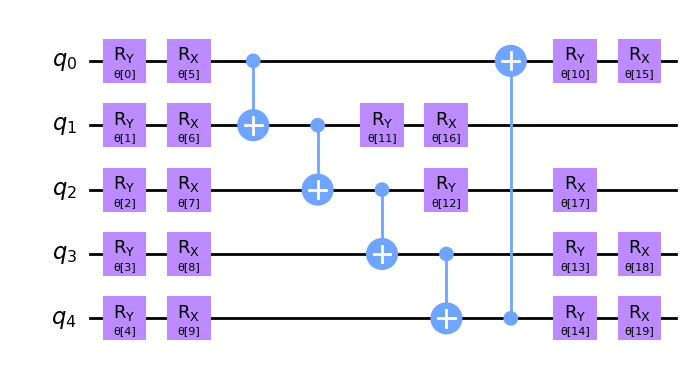

In [7]:
num_qubits = 5
circuit = construct_Ising_like_circ(num_qubits, rotation_blocks = 1)
circuit.draw("mpl")

In [8]:
def construct_Ising_H_1D(num_qubits, g): 
    
    """Method to construct 1d transverse Ising Hamiltonian for n qubits"""
    
    H = 0  # start with a zero hamiltonian
    
    for pos in range(num_qubits): # run over every qubit
        term = 1 # start with 1 to tensor pauli terms onto
        for i in range(num_qubits): # again run over every qubit
            if i != pos: # if not same position then tensor identity
                term = term ^ I
            elif i == pos: # if same position tensor pauli x
                term = term ^ X
                
        H += g * term # add term to hamiltonian for every qubit
        
        
    for pos in range(num_qubits): # run over every qubit
        term = 1 # start with 1 to tensor pauli terms onto
        for i in range(num_qubits): # again run over every qubit
            if i == pos: # if same position tensor pauli z
                term = term ^ Z
            elif i == pos + 1: # if neighboring qubit tensor pauli z
                term = term ^ Z
            elif i + num_qubits - 1 == pos:  # periodic boundary conditions: link nth qubit to first qubit
                term = term^Z
            else:  # otherwise tensor identity
                term = term ^ I
                
        if pos == num_qubits - 1 and num_qubits == 2:  # if only two qubits ensure terms aren't repeated
            break
                
                    
        H += term
        
    return -H        

In [9]:
construct_Ising_H_1D(3, 0.1)

PauliSumOp(SparsePauliOp(['XII', 'IXI', 'IIX', 'ZZI', 'IZZ', 'ZIZ'],
              coeffs=[-0.1+0.j, -0.1+0.j, -0.1+0.j, -1. +0.j, -1. +0.j, -1. +0.j]), coeff=1.0)

In [10]:
def construct_correlation(num_qubits): 
    
    """Method to construct correlation matrix"""
    
    C = 0
        
    for pos in range(num_qubits): # run over every qubit
        term = 1 # start with 1 to tensor pauli terms onto
        for i in range(num_qubits): # again run over every qubit
            if i == pos: # if same position tensor pauli z
                term = term ^ Z
            elif i == pos + 1: # if neighboring qubit tensor pauli z
                term = term ^ Z
            elif i + num_qubits - 1 == pos:  # periodic boundary conditions: link nth qubit to first qubit
                term = term^Z
            else:  # otherwise tensor identity
                term = term ^ I
                
        if pos == num_qubits - 1 and num_qubits == 2:  # if only two qubits ensure terms aren't repeated
            break
                
                    
        C += term
        
    return C 

In [11]:
construct_correlation(6)

PauliSumOp(SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ', 'ZIIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1.0)

In [12]:
def construct_Ising_H_1D_frustration(num_qubits, g): 
    
    """Method to construct 1d transverse Ising Hamiltonian for n qubits"""
    
    H = 0  # start with a zero hamiltonian
    
    for pos in range(num_qubits): # run over every qubit
        term = 1 # start with 1 to tensor pauli terms onto
        for i in range(num_qubits): # again run over every qubit
            if i != pos: # if not same position then tensor identity
                term = term ^ I
            elif i == pos: # if same position tensor pauli x
                term = term ^ X
                
        H += -g * term # add term to hamiltonian for every qubit
        
        
    for pos in range(num_qubits): # run over every qubit
        term = 1 # start with 1 to tensor pauli terms onto
        for i in range(num_qubits): # again run over every qubit
            if i == pos: # if same position tensor pauli z
                term = term ^ Z
            elif i == pos + 1: # if neighboring qubit tensor pauli z
                term = term ^ Z
            elif i + num_qubits - 1 == pos:  # periodic boundary conditions: link nth qubit to first qubit
                term = term^Z
            else:  # otherwise tensor identity
                term = term ^ I
                
        if pos == num_qubits - 1 and num_qubits == 2:  # if only two qubits ensure terms aren't repeated
            break
                
                    
        H += term
        
    return H        

In [13]:
construct_Ising_H_1D_frustration(3,0.1)

PauliSumOp(SparsePauliOp(['XII', 'IXI', 'IIX', 'ZZI', 'IZZ', 'ZIZ'],
              coeffs=[-0.1+0.j, -0.1+0.j, -0.1+0.j,  1. +0.j,  1. +0.j,  1. +0.j]), coeff=1.0)

In [14]:
def construct_magnetization(num_qubits): 
    
    M = 0 
    
    for pos in range(num_qubits):
        term = 1
        for i in range(num_qubits):
            if i != pos:
                term = term ^ I
            elif i == pos:
                term = term ^ Z
                
        M += term
    
    return M

In [15]:
construct_magnetization(6)

PauliSumOp(SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1.0)

In [16]:
def construct_Ising_H_2D(x_dim, y_dim, g): 
    
    
    H = 0
    
    num_qubits = x_dim * y_dim 
    
    for pos in range(num_qubits):
        term = 1
        for i in range(num_qubits):
            if i != pos:
                term = term ^ I
            elif i == pos:
                term = term ^ X
                
        H += g* term
        
    for i in range(num_qubits): 
        
        x_pos = i % x_dim
        y_pos = i // x_dim
        
        flagx = False
        flagy = False
        
        for k in range(2): 
        
            term = 1

            for qubit_xpos in range(x_dim):
                for qubit_ypos in range(y_dim):
                    
                    if qubit_xpos == x_pos and qubit_ypos == y_pos:
                        term = term ^ Z
                    elif qubit_xpos == (x_pos + 1) and qubit_ypos == y_pos and k == 0 and not flagx:
                        term = term ^ Z
                        flagx = True

                    elif x_pos == x_dim - 1 and qubit_ypos == y_pos and k == 0 and not flagx:
                        term = term ^ Z
                        flagx = True

                    elif qubit_xpos == x_pos and qubit_ypos == (y_pos + 1) and k == 1 and not flagy:
                        term = term ^ Z
                        flagy = True

                    elif qubit_xpos == x_pos and y_pos == y_dim - 1 and k == 1 and not flagy:
                        term = term ^ Z
                        flagy = True

                    else:
                        term = term ^ I 
                        
            if (x_dim <= 2) and x_pos == x_dim - 1 and k == 0: 
                term = 0
                
            elif (y_dim <= 2) and y_pos == y_dim - 1 and k == 1: 
                term = 0
                        
            H += term
        
    return -H

In [17]:
def store_data(gs, exact_energies, est_energies, exact_corrs, est_corrs, num_qubits, quantum = False):
    
    now = datetime.now()
    date = now.strftime("%m_%d_%Y")
    time = now.strftime("%H_%M_%S")
    
    folder_path = os.path.join(os.getcwd(), "data",date, time)
    
    os.makedirs(folder_path, exist_ok = True)
    
    data = {"gs": gs, "Exact Energies": exact_energies, "Estimate Energies": est_energies,
           "Exact Correlations": exact_corrs, "Estimate Corr": est_corrs}
    
    frame = pd.DataFrame(data)
    
    if quantum:
    
        csv_path = os.path.join(folder_path, f"Sim_Results_{num_qubits}_quantum.csv")
        
    else:
    
        csv_path = os.path.join(folder_path, f"Sim_Results_{num_qubits}_statevector.csv")
        
    frame.to_csv(csv_path)

In [18]:
def load_data(file_path):
    
    df = pd.read_csv(file_path, index_col = False)

    gs = np.array(df["gs"])
    exact_energies = np.array([df["Exact Energies"]])
    est_energies = np.array([df["Estimate Energies"]])
    exact_corrs = np.array([df["Exact Correlations"]])
    est_corrs = np.array([df["Estimate Correlations"]])
    
    
    return gs, exact_energies, est_energies, exact_corrs, est_corrs
    

In [19]:
def get_exact_results(max_g, min_g, num_qubits,
             loop_iters = 11, store = True, verbose = False): 
    
    gs = []
    exact_energies = []
    exact_corrs = []
    
    for g in 10**np.linspace(min_g,max_g,loop_iters):

        g = np.round(g,3)

        if verbose:
            print(f"Solving Ising Hamiltonian with g={g}")

        Ham = construct_Ising_H_1D(num_qubits, g)
        l, v = np.linalg.eig(np.array(Operator(Ham)))
        idx = np.argmin(l)
        ground_state = Statevector(v[:,idx])
        exact_energies.append(l[idx])

        exact_corr = np.matmul(np.transpose(np.conjugate(ground_state)), np.matmul(corr_mat, ground_state))
        exact_corrs.append(exact_corr/num_qubits)

        if verbose: 
            print(f"Exact Energy: {l[idx]:.3f}")
            print(f"Exact Correlation: {exact_corr/num_qubits:.3f}")
            
#     if store:
#         store_data(gs, exact_energies, exact_corrs, num_qubits)
        

    return gs, exact_energies, exact_corrs


In [20]:
def recreate_eigenstate(counts):

    zero = np.array([[1],[0]])
    one = np.array([[0],[1]])
    
    eigenstate = 0

    for state in counts.keys():

        vector = 1

        for term in state:

            if term == "1": 

                vector = np.kron(vector, one)

            else:
                vector = np.kron(vector, zero)

        eigenstate += vector * counts[state]
        
    return eigenstate

In [21]:
def correlate_counts(counts):
    
    correlation = 0
    
    for state in counts.keys():
        
        correlate = 0
        
        for idx, term in enumerate(state): 
 
            if idx + 1 < len(state):
                neighbor = idx + 1
                
            else: 
                neighbor = 0
            
            if term == state[neighbor]:   
                    correlate += 1 
                    
            else:    
                    correlate += -1
                   
        correlation += correlate * (counts[state] * counts[state])
        
    return correlation

In [34]:
def run_sim(provider, backend, max_g, min_g, num_qubits, optimizer, rot_blocks = 3, 
            shots = 10000, loop_iters = 11, store = True, verbose = False, inner_iters = 1, 
            quantum = False, minimize_circ = False):

    gs = []
    est_energies = []
    exact_energies = []
    est_corrs = []
    exact_corrs = []
    
    solver  = NumPyEigensolver()
    corr_mat = Operator(construct_correlation(num_qubits))

    if verbose: 
        print("Running VQE")
        print("================================================")
        
    for g in 10**np.linspace(min_g, max_g, loop_iters):
        
        if minimize_circ and (g  < 0.1 or g > 10):
            circuit  = construct_Ising_like_circ(num_qubits, rotation_blocks = 1)
            first_layer_params = np.zeros(num_qubits * 2)
            
        else:
            circuit  = construct_Ising_like_circ(num_qubits, rotation_blocks = rot_blocks)
            first_layer_params = np.zeros(num_qubits * 2 * (rot_blocks))
            
            
        val = min(0.001*g*np.pi/4, np.pi/4)
        #last_layer_rx = np.zeros(num_qubits)
        last_layer_ry = np.zeros(num_qubits)
        last_layer_rx2= np.full(num_qubits, val)
        init_params = np.concatenate((first_layer_params,last_layer_ry, last_layer_rx2))

        energies = []
        circ_params = []
        optimal_circs = []
        eigenstates = []

        g = np.round(g,3)

        if verbose:
            print(f"Running Ising Hamiltonian with g={g}")


        Ham = construct_Ising_H_1D(num_qubits, g)
        l, v = np.linalg.eig(np.array(Operator(Ham)))
        idx = np.argmin(l)
        ground_state = Statevector(v[:,idx])
        exact_energies.append(l[idx])

        exact_corr = np.matmul(np.transpose(np.conjugate(ground_state)), np.matmul(corr_mat, ground_state))
        exact_corrs.append(exact_corr/num_qubits)

        for j in range(inner_iters):
            
            if quantum:

                vqe = VQEClient(ansatz=circuit, optimizer=optimizer, 
                              initial_point = init_params, backend = backend, provider = provider, shots = shots, 
                               measurement_error_mitigation=False)
                result = vqe.compute_minimum_eigenvalue(Ham)
                energies.append(result.eigenvalue)
                eigenstates.append(result.eigenstate)
                
            else: 
                    
                estimator = Estimator()
                vqe = VQE(estimator = estimator, ansatz=circuit, optimizer=optimizer, 
                          initial_point = init_params)
                result = vqe.compute_minimum_eigenvalue(Ham)
                energies.append(result.eigenvalue)
                circ_params.append(result.optimal_parameters)
                optimal_circs.append(result.optimal_circuit)
    
        if not quantum:
    
            qc = optimal_circs[np.argmin(energies)].bind_parameters(circ_params[np.argmin(energies)])
            qc = qc.decompose()
            job = backend.run(qc, counts = shots)
            res = job.result()
            outputstate = res.get_statevector(qc, decimals=3)

        else:
            outputstate = Statevector(recreate_eigenstate(eigenstates[np.argmin(energies)]))
            

        gs.append(g)
        est_energies.append(np.min(energies))

        corr = np.matmul(np.transpose(np.conjugate(outputstate)), np.matmul(corr_mat, outputstate))
        est_corrs.append(corr/num_qubits)

        if verbose:
            print(f"Exact Energy: {l[idx]:.3f}, Estimate Energy: {np.min(energies):.3f}")
            print(f"Exact Correlation: {exact_corr/num_qubits:.3f}, Estimate Correlation: {corr/num_qubits:.3f}")
            
    if store:
        store_data(gs, exact_energies, est_energies, exact_corrs, est_corrs, num_qubits, quantum = quantum)

    return gs, exact_energies, est_energies, exact_corrs, est_corrs


In [35]:
def run_sim_frustration(provider, backend, max_g, min_g, num_qubits, optimizer, rot_blocks = 3, 
            shots = 10000, loop_iters = 11, store = True, verbose = False, inner_iters = 1, 
            quantum = False, minimize_circ = False):

    gs = []
    est_energies = []
    exact_energies = []
    est_corrs = []
    exact_corrs = []
    
    solver  = NumPyEigensolver()
    corr_mat = Operator(construct_correlation(num_qubits))

    if verbose: 
        print("Running VQE")
        print("================================================")
        
    for g in 10**np.linspace(min_g, max_g, loop_iters):
        
        if minimize_circ and (g  < 0.1 or g > 10):
            circuit  = construct_Ising_like_circ(num_qubits, rotation_blocks = 1)
            first_layer_params = np.zeros(num_qubits * 2)
            
        else:
            circuit  = construct_Ising_like_circ(num_qubits, rotation_blocks = rot_blocks)
            first_layer_params = np.zeros(num_qubits * 2 * (rot_blocks))
            
            
        val = min(0.001*g*np.pi/4, np.pi/4)
        #last_layer_rx = np.zeros(num_qubits)
        last_layer_ry = np.zeros(num_qubits)
        last_layer_rx2= np.full(num_qubits, val)
        init_params = np.concatenate((first_layer_params,last_layer_ry, last_layer_rx2))

        energies = []
        circ_params = []
        optimal_circs = []
        eigenstates = []

        g = np.round(g,3)

        if verbose:
            print(f"Running Ising Hamiltonian with g={g}")


        Ham = construct_Ising_H_1D_frustration(num_qubits, g)
        l, v = np.linalg.eig(np.array(Operator(Ham)))
        idx = np.argmin(l)
        ground_state = Statevector(v[:,idx])
        exact_energies.append(l[idx])

        exact_corr = np.matmul(np.transpose(np.conjugate(ground_state)), np.matmul(corr_mat, ground_state))
        exact_corrs.append(exact_corr/num_qubits)

        for j in range(inner_iters):
            
            if quantum:

                vqe = VQEClient(ansatz=circuit, optimizer=optimizer, 
                              initial_point = init_params, backend = backend, provider = provider, shots = shots, 
                               measurement_error_mitigation=False)
                result = vqe.compute_minimum_eigenvalue(Ham)
                energies.append(result.eigenvalue)
                eigenstates.append(result.eigenstate)
                
            else: 
                    
                estimator = Estimator()
                vqe = VQE(estimator = estimator, ansatz=circuit, optimizer=optimizer, 
                          initial_point = init_params)
                result = vqe.compute_minimum_eigenvalue(Ham)
                energies.append(result.eigenvalue)
                circ_params.append(result.optimal_parameters)
                optimal_circs.append(result.optimal_circuit)
    
        if not quantum:
    
            qc = optimal_circs[np.argmin(energies)].bind_parameters(circ_params[np.argmin(energies)])
            qc = qc.decompose()
            job = backend.run(qc, counts = shots)
            res = job.result()
            outputstate = res.get_statevector(qc, decimals=3)

        else:
            outputstate = Statevector(recreate_eigenstate(eigenstates[np.argmin(energies)]))
            

        gs.append(g)
        est_energies.append(np.min(energies))

        corr = np.matmul(np.transpose(np.conjugate(outputstate)), np.matmul(corr_mat, outputstate))
        est_corrs.append(corr/num_qubits)

        if verbose:
            print(f"Exact Energy: {l[idx]:.3f}, Estimate Energy: {np.min(energies):.3f}")
            print(f"Exact Correlation: {exact_corr/num_qubits:.3f}, Estimate Correlation: {corr/num_qubits:.3f}")
            
    if store:
        store_data(gs, exact_energies, est_energies, exact_corrs, est_corrs, num_qubits, quantum = quantum)

    return gs, exact_energies, est_energies, exact_corrs, est_corrs


In [24]:
def plot_correlations(num_qubits, gs, exact_corrs, est_corrs , quantum = False, 
                     fig = None, ax = None, colors = None, gs_q = None, exact_corrs_q = None, est_corrs_q = None):
    
    assert ((not quantum) or quantum  and 
            exact_corrs_q is not None and est_corrs_q is not None and gs_q is not None), "Quantum Arg but no Data"
    
    if ax is None and fig is None:
        fig,ax = plt.subplots()
    max_height = max(np.max(est_corrs), np.max(exact_corrs))
    min_height = min(np.min(est_corrs), np.min(exact_corrs))
    
    ax.plot(np.full(8, 1), np.linspace(min_height, max_height, 8), linestyle = "dashed", color = "red")
    
    if colors is None:
        ax.plot(gs, exact_corrs, color ="forestgreen", label = f"Exact Correlation - {num_qubits} qubits")
        ax.plot(gs, est_corrs,"k+", label = f"Estimated Correlation with Simulator - {num_qubits} qubits")
    
    else: 
        ax.plot(gs, exact_corrs, color = colors[0],label = f"Exact Correlation for {num_qubits} qubits")
        ax.plot(gs, est_corrs,"+",color = colors[1],
                label = f"Estimated Correlation with Classical Simulator - {num_qubits} qubits")
        
    
    if quantum:
        ax.plot(gs_q, est_corrs_q,"mx", label = f"Estimated Correlation with IBM Oslo - {num_qubits} qubits")
        
    ax.set_xscale("log")
    ax.set_title("Correlation of the Ising Model")
    ax.set_ylabel("Correlation")
    ax.set_xlabel("Strength of Transverse Field")
    ax.legend(loc = "best")
    fig.set_size_inches(12, 8.5)
    
    return fig,ax

In [25]:
def plot_energies(num_qubits, gs, exact_energies, est_energies, quantum = False, 
                     fig = None, ax = None, colors = None, gs_q = None, exact_energies_q = None, 
                  est_energies_q = None, per_site = False):
    
    assert ((not quantum) or quantum  and 
            exact_corrs_q is not None and est_corrs_q is not None and gs_q is not None), "Quantum Arg but no Data"
    
    if ax is None and fig is None:
        fig,ax = plt.subplots()
        
    if not quantum: 
        max_height = max(np.max(est_energies), np.max(exact_energies))
        min_height = min(np.min(est_energies), np.min(exact_energies))

    else: 
        max_height = max(max(np.max(est_energies), np.max(exact_energies)), np.max(est_energies_q))
        min_height = min(min(np.min(est_energies), np.min(exact_energies)), np.min(exact_energies_q))
        
    ax.plot(np.full(8, 1), np.linspace(min_height, max_height, 8), linestyle = "dashed", color = "red")
    
    if colors is None:
        ax.plot(gs, exact_energies,label = f"Exact Energy - {num_qubits} qubits")
        ax.plot(gs, est_energies, "x", color ="forestgreen", 
                label = f"Estimated Energy with Simulator - {num_qubits} qubits")
        
    else: 
        ax.plot(gs, exact_energies, color = colors[0], label = f"Exact Energy for {num_qubits} qubits")
        ax.plot(gs, est_energies,"+",color = colors[1],label = f"Estimated Energy with Classical Simulator - {num_qubits} qubits")
        
    if quantum:
        ax.plot(gs_q, est_energies_q,"mx", label = f"Estimated Energy with IBM Oslo - {num_qubits} qubits")
        

    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    ax.set_title("Energy of the Ising Model")
    if not per_site:
        ax.set_ylabel("Energy")
    else: 
        ax.set_ylabel("Energy per Site")
    ax.set_xlabel("Strength of Transverse Field")
    ax.legend(loc = "best")
    fig.set_size_inches(12, 8.5)
    
    return fig, ax

In [26]:
def write_text(fig,ax, ord_text_coords, dis_text_coords, arrow_coords, label_coords):
    ax.text(ord_text_coords[0],ord_text_coords[1], "Ordered Regime", transform=ax.transAxes)
    ax.text(dis_text_coords[0],dis_text_coords[1], "Disordered Regime", transform=ax.transAxes)
    ax.arrow(arrow_coords[0], arrow_coords[1], arrow_coords[2], arrow_coords[3],transform=ax.transAxes,  head_width = 0.01, color = "red")
    ax.text(label_coords[0], label_coords[1], "Phase Transistion", transform=ax.transAxes)
    return fig, ax

In [27]:
def write_text_frust(fig,ax,arrow_coords, label_coords):
    ax.arrow(arrow_coords[0], arrow_coords[1], arrow_coords[2], arrow_coords[3],transform=ax.transAxes,  head_width = 0.01, color = "red")
    ax.text(label_coords[0], label_coords[1], "Phase Transistion", transform=ax.transAxes)
    return fig, ax

## Use Statevector Simulator for Noiseless Simulation

In [21]:
backend = Aer.get_backend('statevector_simulator')

shots = 2048
max_iters = 100
loop_iters = 16
max_g = 2
min_g= -2
rot_blocks = 2
num_qubits = 5

optimizer = SLSQP(maxiter=max_iters, ftol = 1e-8)

results = run_sim(provider, backend, max_g, min_g, num_qubits, optimizer, rot_blocks = rot_blocks,
                  shots = shots, loop_iters = loop_iters, verbose = True, quantum = False)
    
gs = results[0]
exact_energies = results[1]
est_energies = results[2]
exact_corrs = results[3]
est_corrs = results[4]

Running VQE
Running Ising Hamiltonian with g=0.01
Exact Energy: -5.000+0.000j, Estimate Energy: -5.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.018
Exact Energy: -5.000+0.000j, Estimate Energy: -5.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.034
Exact Energy: -5.001+0.000j, Estimate Energy: -5.001
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.063
Exact Energy: -5.005+0.000j, Estimate Energy: -5.005
Exact Correlation: 0.999+0.000j, Estimate Correlation: 0.998+0.000j
Running Ising Hamiltonian with g=0.117
Exact Energy: -5.017+0.000j, Estimate Energy: -5.017
Exact Correlation: 0.997+0.000j, Estimate Correlation: 0.997+0.000j
Running Ising Hamiltonian with g=0.215
Exact Energy: -5.058+0.000j, Estimate Energy: -5.058
Exact Correlation: 0.988+0.000j, Estimate Correlation: 0.989+0.000j
Running Ising Hamiltonian wit

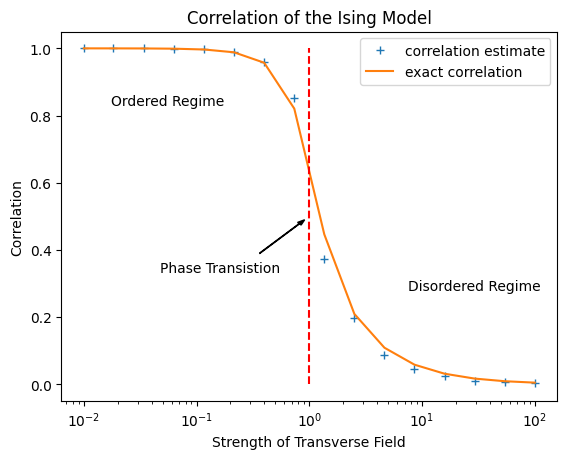

In [186]:
fig,ax = plt.subplots()
ax.plot(gs, est_corrs,"+", label = "correlation estimate")
ax.plot(gs, exact_corrs, label = "exact correlation")
max_height = max(np.max(est_corrs), np.max(exact_corrs))
min_height = min(np.min(est_corrs), np.min(exact_corrs))
ax.plot(np.full(len(gs), 1), np.linspace(0, 1, len(gs)), linestyle = "dashed", color = "red")
ax.text(0.1,0.8, "Ordered Regime", transform=ax.transAxes)
ax.text(0.7,0.3, "Disordered Regime", transform=ax.transAxes)
ax.arrow(0.4, 0.4, 0.08, 0.08,transform=ax.transAxes,  head_width = 0.01, color = "black")
ax.text(0.2, 0.35, "Phase Transistion",transform=ax.transAxes)
ax.set_xscale("log")
ax.set_title("Correlation of the Ising Model")
ax.set_ylabel("Correlation")
ax.set_xlabel("Strength of Transverse Field")
ax.set_xlabel
ax.legend()

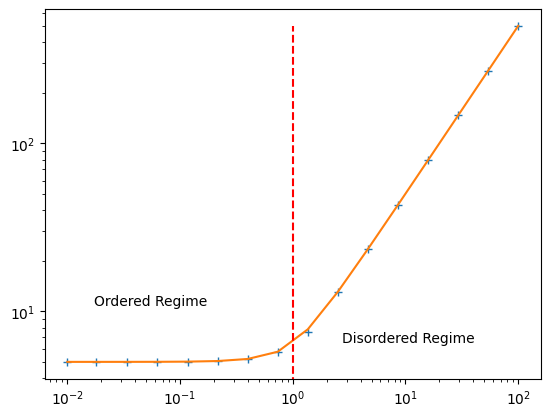

In [187]:
fig,ax = plt.subplots()
flip_sign_est = -1*np.array(est_energies)
flip_sign_exact = -1*np.array(exact_energies)
ax.plot(gs, flip_sign_est,"+", label = "energy estimate")
ax.plot(gs, flip_sign_exact, label = "exact energy")
max_height = max(np.max(flip_sign_est), np.max(flip_sign_exact))
min_height = min(np.min(flip_sign_est), np.min(flip_sign_exact))
ax.plot(np.full(len(gs), 1), np.linspace(0, max_height, len(gs)), linestyle = "dashed", color = "red")
ax.text(0.1,0.2, "Ordered Regime", transform=ax.transAxes)
ax.text(0.6,0.1, "Disordered Regime", transform=ax.transAxes)
ax.set_xscale("log")
ax.set_yscale("log")

## Try on Actual Quantum Computer

In [12]:
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-12-02 12:22:52,154: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [13]:
provider = IBMQ.get_provider()

In [14]:
pot_backends = provider.backends(filters=lambda x: x.configuration().n_qubits >= 3
                                    and not x.configuration().simulator
                                    and x.status().operational==True
                                    and x.configuration().quantum_volume > 16)

In [15]:
for backend in pot_backends:
    print(f"name: {backend}, qubits: {backend.configuration().n_qubits}, QV: {backend.configuration().quantum_volume}")

name: ibmq_manila, qubits: 5, QV: 32
name: ibm_nairobi, qubits: 7, QV: 32
name: ibm_oslo, qubits: 7, QV: 32


In [189]:
backend = provider.get_backend("ibmq_manila")

shots = 2048
max_iters = 100
loop_iters = 16
max_g = 2
min_g= -2
rot_blocks = 1
num_qubits = 5


optimizer = SPSA(maxiter=max_iters)

results_q = run_sim(provider, backend, max_g, min_g, num_qubits, optimizer, rot_blocks = rot_blocks,
                  shots = shots, loop_iters = loop_iters, verbose = True, quantum = True)
    
gs_q = results_q[0]
exact_energies_q = results_q[1]
est_energies_q = results_q[2]
exact_corrs_q = results_q[3]
est_corrs_q = results_q[4]

Running VQE
Running Ising Hamiltonian with g=0.01
Exact Energy: -5.000+0.000j, Estimate Energy: -2.194+0.000j
Exact Correlation: 1.000+0.000j, Estimate Correlation: 0.307+0.000j
Running Ising Hamiltonian with g=0.018
Exact Energy: -5.000+0.000j, Estimate Energy: -2.254+0.000j
Exact Correlation: 1.000+0.000j, Estimate Correlation: 0.396+0.000j
Running Ising Hamiltonian with g=0.034
Exact Energy: -5.001+0.000j, Estimate Energy: -1.852+0.000j
Exact Correlation: 1.000+0.000j, Estimate Correlation: 0.411+0.000j
Running Ising Hamiltonian with g=0.063
Exact Energy: -5.005+0.000j, Estimate Energy: -1.782+0.000j
Exact Correlation: 0.999+0.000j, Estimate Correlation: 0.277+0.000j
Running Ising Hamiltonian with g=0.117
Exact Energy: -5.017+0.000j, Estimate Energy: -1.840+0.000j
Exact Correlation: 0.997+0.000j, Estimate Correlation: 0.277+0.000j
Running Ising Hamiltonian with g=0.215
Exact Energy: -5.058+0.000j, Estimate Energy: -2.053+0.000j
Exact Correlation: 0.988+0.000j, Estimate Correlation: 

### Graph Results

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


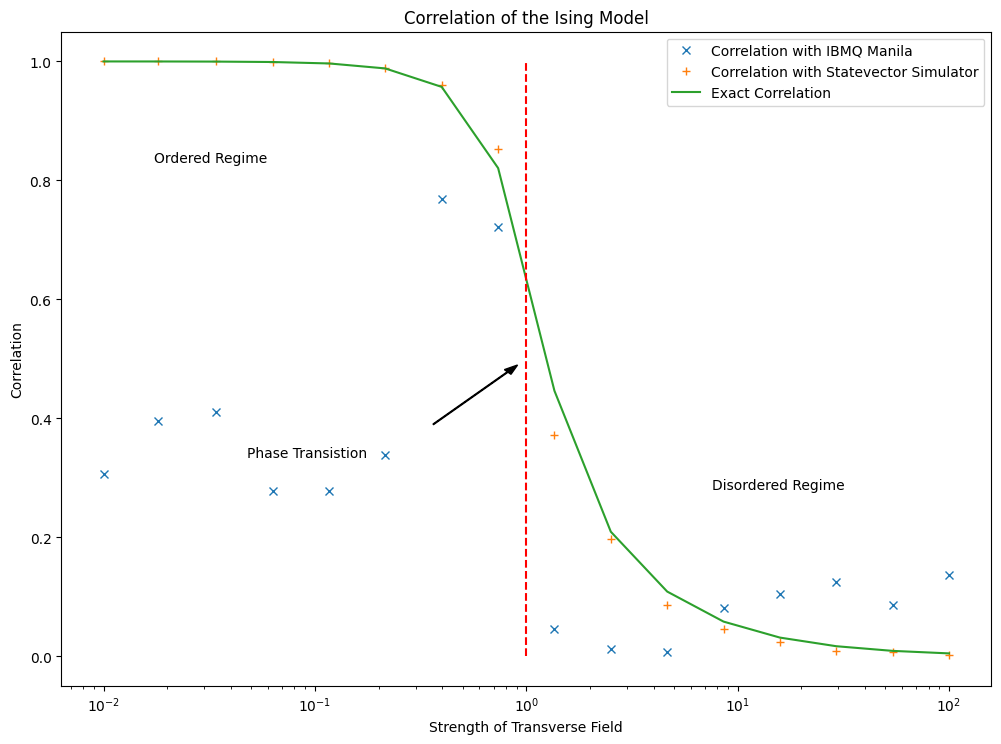

In [190]:
fig,ax = plt.subplots()
ax.plot(gs_q, est_corrs_q,"x", label = "Correlation with IBMQ Manila")
ax.plot(gs, est_corrs,"+", label = "Correlation with Statevector Simulator")
ax.plot(gs, exact_corrs, label = "Exact Correlation")
max_height = max(np.max(est_corrs), np.max(exact_corrs))
min_height = min(np.min(est_corrs), np.min(exact_corrs))
ax.plot(np.full(len(gs), 1), np.linspace(0, 1, len(gs)), linestyle = "dashed", color = "red")
ax.text(0.1,0.8, "Ordered Regime", transform=ax.transAxes)
ax.text(0.7,0.3, "Disordered Regime", transform=ax.transAxes)
ax.arrow(0.4, 0.4, 0.08, 0.08,transform=ax.transAxes,  head_width = 0.01, color = "black")
ax.text(0.2, 0.35, "Phase Transistion", transform=ax.transAxes)
ax.set_xscale("log")
ax.set_title("Correlation of the Ising Model")
ax.set_ylabel("Correlation")
ax.set_xlabel("Strength of Transverse Field")
ax.set_xlabel
ax.legend(loc = "best")
fig.set_size_inches(12, 8.5)

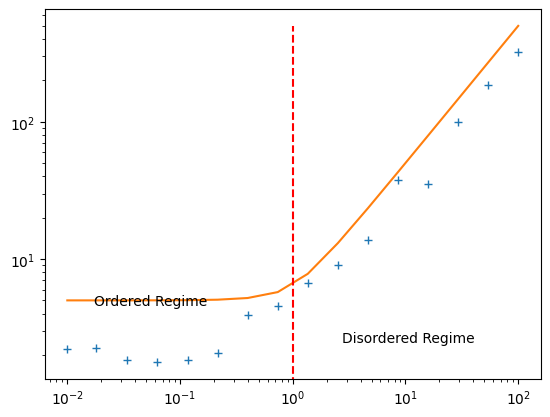

In [191]:
fig,ax = plt.subplots()
flip_sign_est_q = -1*np.array(est_energies_q)
flip_sign_exact_q = -1*np.array(exact_energies_q)
ax.plot(gs_q, flip_sign_est_q,"+", label = "energy estimate")
ax.plot(gs_q, flip_sign_exact_q, label = "exact energy")
max_height = max(np.max(flip_sign_est_q), np.max(flip_sign_exact_q))
min_height = min(np.min(flip_sign_est_q), np.min(flip_sign_exact_q))
ax.plot(np.full(len(gs_q), 1), np.linspace(0, max_height, len(gs_q)), linestyle = "dashed", color = "red")
ax.text(0.1,0.2, "Ordered Regime", transform=ax.transAxes)
ax.text(0.6,0.1, "Disordered Regime", transform=ax.transAxes)
ax.set_xscale("log")
ax.set_yscale("log")

## Try changing circuit in method to reduce circuit depth and errors

In [104]:
# Run on 12/3/2022 at 1520 (to find datafile)

backend = Aer.get_backend('statevector_simulator')

shots = 2048
max_iters = 100
loop_iters = 21
max_g = 2
min_g= -2
rot_blocks = 2
num_qubits = 5

optimizer = SLSQP(maxiter=max_iters, ftol = 1e-8)

results = run_sim(provider, backend, max_g, min_g, num_qubits, optimizer, rot_blocks = rot_blocks,
                  shots = shots, loop_iters = loop_iters, verbose = True, quantum = False, minimize_circ = True)
    
gs = results[0]
exact_energies = results[1]
est_energies = results[2]
exact_corrs = results[3]
est_corrs = results[4]

Running VQE
Running Ising Hamiltonian with g=0.01
Exact Energy: -5.000+0.000j, Estimate Energy: -5.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.016
Exact Energy: -5.000+0.000j, Estimate Energy: -5.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.025
Exact Energy: -5.001+0.000j, Estimate Energy: -5.001
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.04
Exact Energy: -5.002+0.000j, Estimate Energy: -5.002
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.063
Exact Energy: -5.005+0.000j, Estimate Energy: -5.005
Exact Correlation: 0.999+0.000j, Estimate Correlation: 0.998+0.000j
Running Ising Hamiltonian with g=0.1
Exact Energy: -5.013+0.000j, Estimate Energy: -5.013
Exact Correlation: 0.997+0.000j, Estimate Correlation: 0.997+0.000j
Running Ising Hamiltonian with g

In [28]:
# run without meas error mitigation on 12/5/2022 at 1731

backend = provider.get_backend("ibm_oslo")

shots = 2048
max_iters = 100
loop_iters = 21
max_g = 2
min_g= -2
rot_blocks = 2
num_qubits = 5

optimizer = SPSA(maxiter=max_iters)

results_q = run_sim(provider, backend, max_g, min_g, num_qubits, optimizer, rot_blocks = rot_blocks,
                  shots = shots, loop_iters = loop_iters, verbose = True, quantum = True, minimize_circ = True)
    
gs_q = results_q[0]
exact_energies_q = results_q[1]
est_energies_q = results_q[2]
exact_corrs_q = results_q[3]
est_corrs_q = results_q[4]

Running VQE
Running Ising Hamiltonian with g=0.01
Exact Energy: -5.000+0.000j, Estimate Energy: -2.199+0.000j
Exact Correlation: 1.000+0.000j, Estimate Correlation: 0.433+0.000j
Running Ising Hamiltonian with g=0.016
Exact Energy: -5.000+0.000j, Estimate Energy: -2.283+0.000j
Exact Correlation: 1.000+0.000j, Estimate Correlation: 0.275+0.000j
Running Ising Hamiltonian with g=0.025
Exact Energy: -5.001+0.000j, Estimate Energy: -1.598+0.000j
Exact Correlation: 1.000+0.000j, Estimate Correlation: 0.107+0.000j
Running Ising Hamiltonian with g=0.04
Exact Energy: -5.002+0.000j, Estimate Energy: -2.209+0.000j
Exact Correlation: 1.000+0.000j, Estimate Correlation: 0.409+0.000j
Running Ising Hamiltonian with g=0.063
Exact Energy: -5.005+0.000j, Estimate Energy: -2.229+0.000j
Exact Correlation: 0.999+0.000j, Estimate Correlation: 0.407+0.000j
Running Ising Hamiltonian with g=0.1
Exact Energy: -5.013+0.000j, Estimate Energy: -2.041+0.000j
Exact Correlation: 0.997+0.000j, Estimate Correlation: 0.1

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


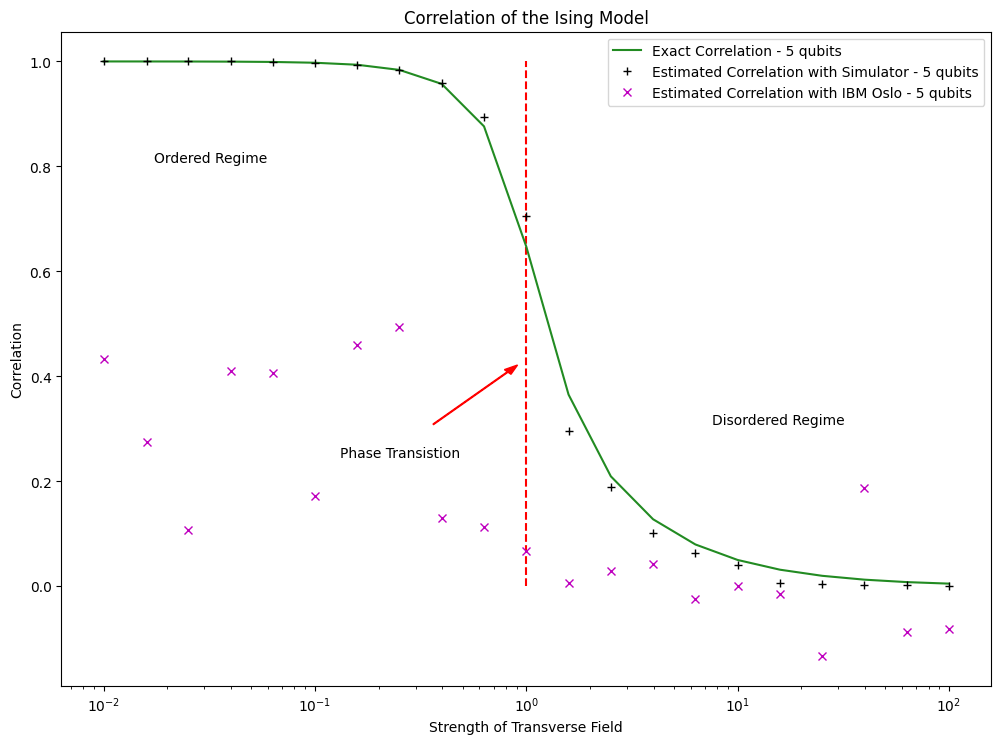

In [188]:
# finished 12/6/2022 at 2013

d_text_coords = (0.7,0.4)
o_text_coords = (0.1,0.8)
arr_coords = (0.4, 0.4, 0.08, 0.08)
lab_coords = (0.3, 0.35)

fig_c_q, ax_c_q = plot_correlations(num_qubits,gs,exact_corrs, est_corrs,
                  quantum = True, 
                  gs_q = gs_q, exact_corrs_q = exact_corrs_q, est_corrs_q = est_corrs_q)


fig_c_q, ax_c_q = write_text(fig_c_q,ax_c_q, o_text_coords,d_text_coords, arr_coords, lab_coords)


fig_c_q.savefig(os.path.join(os.getcwd(), "images", "Correlation_5_qubits_quantum.jpg"))

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


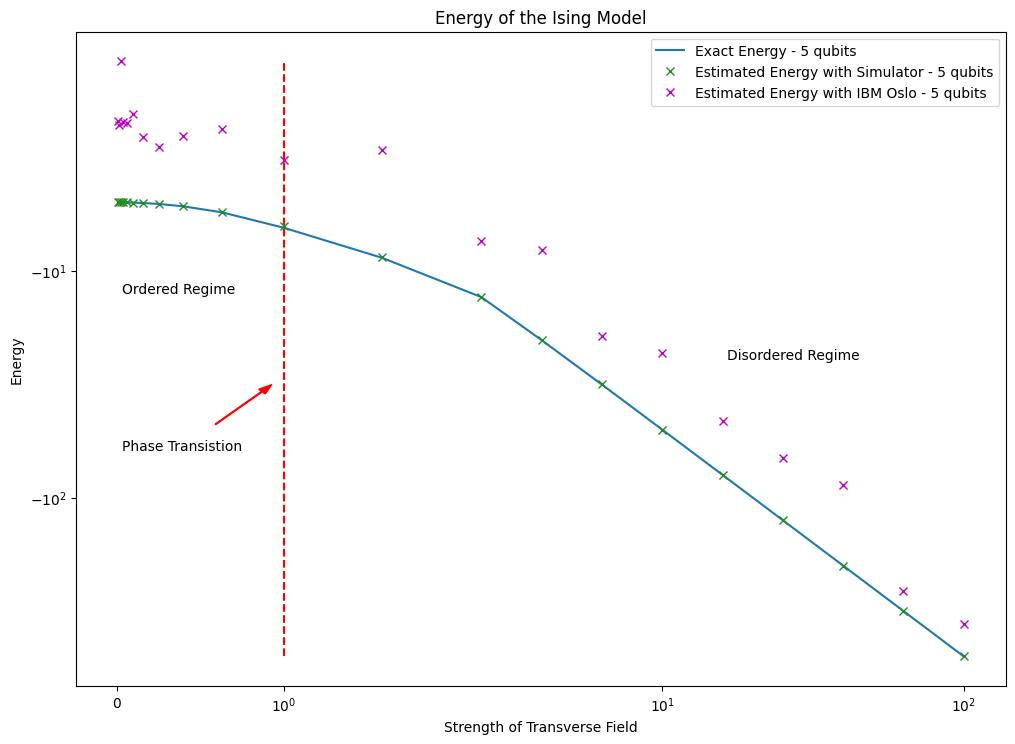

In [214]:
d_text_coords = (0.7,0.5)
o_text_coords = (0.05,0.6)
arr_coords = (0.15, 0.4, 0.05, 0.05)
lab_coords = (0.05, 0.36)

fig_e_q, ax_e_q = plot_energies(num_qubits,gs,exact_energies, est_energies,
                  quantum = True, 
                  gs_q = gs_q, exact_energies_q = exact_energies_q, est_energies_q = est_energies_q)

fig_e_q, ax_e_q = write_text(fig_e_q,ax_e_q, o_text_coords,d_text_coords, arr_coords, lab_coords)

fig_e_q.savefig(os.path.join(os.getcwd(), "images", "Energy_5_qubits_quantum.jpg"))

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


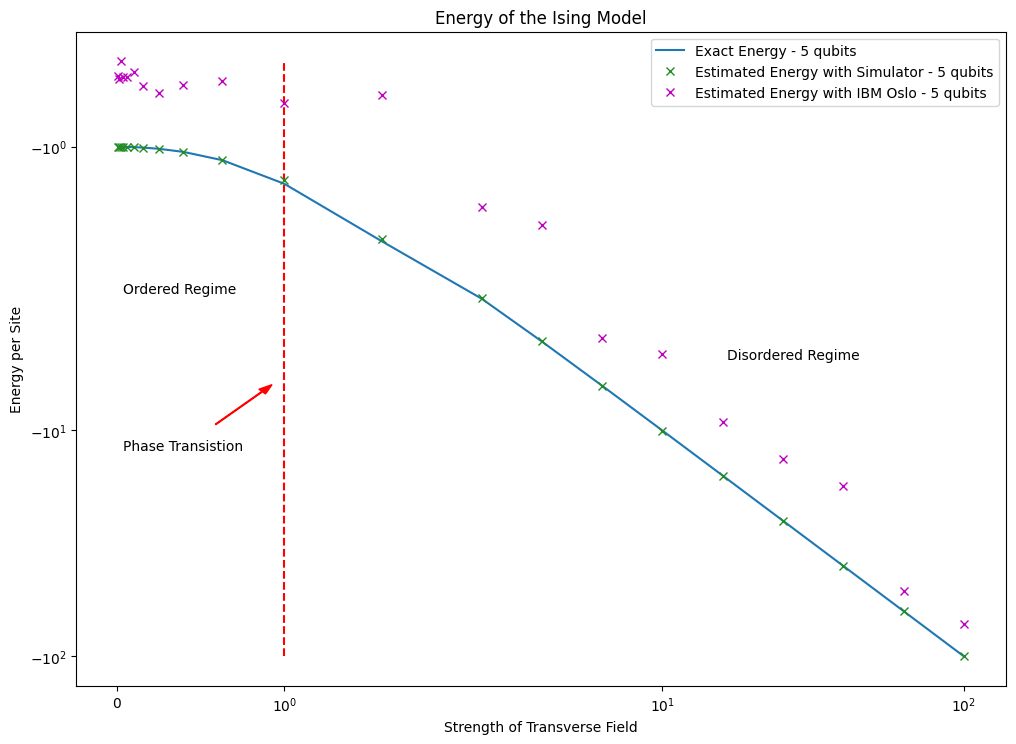

In [215]:
d_text_coords = (0.7,0.5)
o_text_coords = (0.05,0.6)
arr_coords = (0.15, 0.4, 0.05, 0.05)
lab_coords = (0.05, 0.36)

fig_e_q_s, ax_e_q_s = plot_energies(num_qubits,gs,np.array(exact_energies)/num_qubits, 
              np.array(est_energies)/num_qubits, quantum = True, gs_q = gs_q, 
              exact_energies_q = np.array(exact_energies_q)/num_qubits, 
              est_energies_q = np.array(est_energies_q)/num_qubits, per_site = True)
    

fig_e_q_s, ax_e_q_s = write_text(fig_e_q_s,ax_e_q_s, o_text_coords,d_text_coords, arr_coords, lab_coords)


fig_e_q_s.savefig(os.path.join(os.getcwd(), "images", "Energy_per_site_5_qubits_quantum.jpg"))

### Classical Simulation results with varying number of spin particles

 
Model with 3 qubits
Running VQE
Running Ising Hamiltonian with g=0.01
Exact Energy: -3.000+0.000j, Estimate Energy: -3.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.016
Exact Energy: -3.000+0.000j, Estimate Energy: -3.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.025
Exact Energy: -3.000+0.000j, Estimate Energy: -3.000
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.04
Exact Energy: -3.001+0.000j, Estimate Energy: -3.001
Exact Correlation: 1.000+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.063
Exact Energy: -3.003+0.000j, Estimate Energy: -3.003
Exact Correlation: 0.999+0.000j, Estimate Correlation: 1.000+0.000j
Running Ising Hamiltonian with g=0.1
Exact Energy: -3.008+0.000j, Estimate Energy: -3.008
Exact Correlation: 0.997+0.000j, Estimate Correlation: 0.998+0.000j
Running Is


KeyboardInterrupt



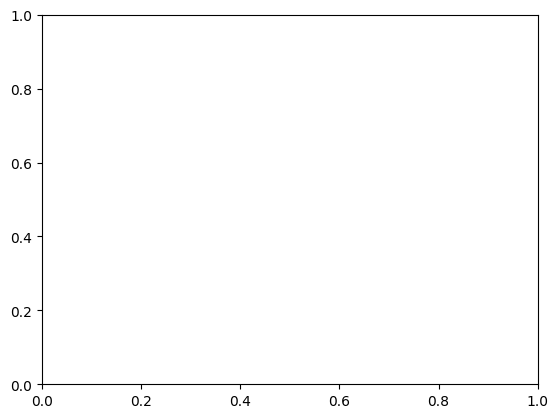

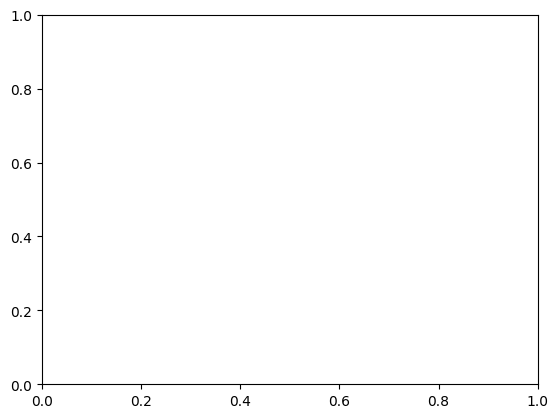

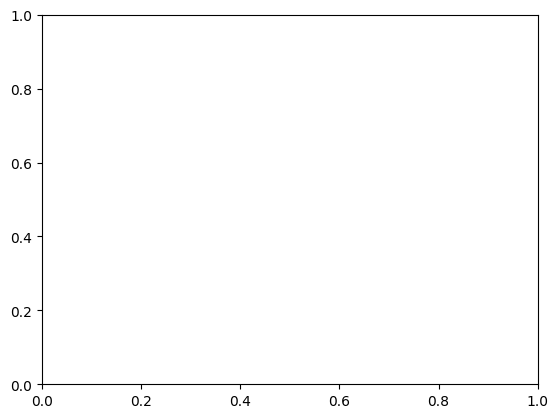

In [36]:
# Run on 12/6/2022 at 2332 (to find datafile)

d_text_coords_c = (0.7,0.3)
o_text_coords_c = (0.1,0.8)
arr_coords_c = (0.4, 0.4, 0.08, 0.08)
lab_coords_c = (0.3, 0.35)

d_text_coords_e = (0.7,0.5)
o_text_coords_e = (0.05,0.6)
arr_coords_e = (0.12, 0.4, 0.08, 0.08)
lab_coords_e = (0.06, 0.35)

colors = [["blue", "blue"],["black","black"], 
                            ["green", "green"], ["red","red"]]
          
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
backend = Aer.get_backend('statevector_simulator')

for idx, num_q in enumerate([3,5,7,9]):
    
    print(" ")
    print(f"Model with {num_q} qubits")

    shots = 2048
    max_iters = 100
    loop_iters = 21
    max_g = 2
    min_g= -2
    rot_blocks = 2

    optimizer = SLSQP(maxiter=max_iters, ftol = 1e-8)

    results_n = run_sim(provider, backend, max_g, min_g, num_q, optimizer, rot_blocks = rot_blocks,
                      shots = shots, loop_iters = loop_iters, verbose = True, quantum = False, minimize_circ = True)

    gs_n = results_n[0]
    exact_energies_n = results_n[1]
    est_energies_n = results_n[2]
    exact_corrs_n = results_n[3]
    est_corrs_n = results_n[4]
    
    fig_c_n, ax_c_n = plot_correlations(num_q,gs_n,exact_corrs_n, est_corrs_n, 
                      fig = fig1, ax = ax1, colors = colors[idx])
    
        
    fig_e_n, ax_e_n = plot_energies(num_q,gs_n,exact_energies_n, est_energies_n, 
                      fig = fig2, ax = ax2, colors = colors[idx])
    
    
    fig_e_n_s, ax_e_n_s = plot_energies(num_q,gs_n,np.array(exact_energies_n)/num_q, np.array(est_energies_n)/num_q,
                      fig = fig3, ax = ax3, colors = colors[idx], per_site = True)

In [ ]:
fig_c_n, ax_c_n= write_text(fig_c_n,ax_c_n, o_text_coords_c,d_text_coords_c, arr_coords_c, lab_coords_c)
fig_e_n, ax_e_n= write_text(fig_e_n,ax_e_n, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)
fig_e_n_s, ax_e_n_s= write_text(fig_e_n_s,ax_e_n_s, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)
    
fig_c_n.savefig(os.path.join(os.getcwd(), "images", "Correlation_multiple_qubits.jpg"))
fig_e_n.savefig(os.path.join(os.getcwd(), "images", "Energy_multiple_qubits.jpg"))
fig_e_n_s.savefig(os.path.join(os.getcwd(), "images", "Energy_per_site_multiple_qubits.jpg"))

## More closely examine phase transition region

 
Model with 3 qubits
Running VQE
Running Ising Hamiltonian with g=0.631
Exact Energy: -3.383+0.000j, Estimate Energy: -3.313
Exact Correlation: 0.854+0.000j, Estimate Correlation: 0.886+0.000j
Running Ising Hamiltonian with g=0.661
Exact Energy: -3.423+0.000j, Estimate Energy: -3.345
Exact Correlation: 0.840+0.000j, Estimate Correlation: 0.874+0.000j
Running Ising Hamiltonian with g=0.692
Exact Energy: -3.466+0.000j, Estimate Energy: -3.380
Exact Correlation: 0.825+0.000j, Estimate Correlation: 0.860+0.000j
Running Ising Hamiltonian with g=0.724
Exact Energy: -3.513+0.000j, Estimate Energy: -3.418
Exact Correlation: 0.809+0.000j, Estimate Correlation: 0.844+0.000j
Running Ising Hamiltonian with g=0.759
Exact Energy: -3.567+0.000j, Estimate Energy: -3.462
Exact Correlation: 0.791+0.000j, Estimate Correlation: 0.828+0.000j
Running Ising Hamiltonian with g=0.794
Exact Energy: -3.623+0.000j, Estimate Energy: -3.508
Exact Correlation: 0.773+0.000j, Estimate Correlation: 0.809+0.000j
Runnin

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Exact Energy: -5.534+0.000j, Estimate Energy: -5.508
Exact Correlation: 0.876+0.000j, Estimate Correlation: 0.895+0.000j
Running Ising Hamiltonian with g=0.661
Exact Energy: -5.590+0.000j, Estimate Energy: -5.558
Exact Correlation: 0.862+0.000j, Estimate Correlation: 0.884-0.000j
Running Ising Hamiltonian with g=0.692
Exact Energy: -5.652+0.000j, Estimate Energy: -5.613
Exact Correlation: 0.845-0.000j, Estimate Correlation: 0.872+0.000j
Running Ising Hamiltonian with g=0.724
Exact Energy: -5.720+0.000j, Estimate Energy: -5.673
Exact Correlation: 0.828+0.000j, Estimate Correlation: 0.858+0.000j
Running Ising Hamiltonian with g=0.759
Exact Energy: -5.799+0.000j, Estimate Energy: -5.742
Exact Correlation: 0.807+0.000j, Estimate Correlation: 0.842+0.000j
Running Ising Hamiltonian with g=0.794
Exact Energy: -5.883+0.000j, Estimate Energy: -5.815
Exact Correlation: 0.785-0.000j, Estimate Correlation: 0.826+0.000j
Running Ising Hamiltonian with g=0.832
Exact Energy: -5.979+0.000j, Estimate En

Exact Energy: -11.266-0.000j, Estimate Energy: -11.160
Exact Correlation: 0.679+0.000j, Estimate Correlation: 0.734+0.000j
Running Ising Hamiltonian with g=1.0
Exact Energy: -11.518+0.000j, Estimate Energy: -11.381
Exact Correlation: 0.640+0.000j, Estimate Correlation: 0.703+0.000j
Running Ising Hamiltonian with g=1.047
Exact Energy: -11.797-0.000j, Estimate Energy: -11.625
Exact Correlation: 0.600+0.000j, Estimate Correlation: 0.669+0.000j
Running Ising Hamiltonian with g=1.096
Exact Energy: -12.104-0.000j, Estimate Energy: -11.896
Exact Correlation: 0.561+0.000j, Estimate Correlation: 0.629-0.000j
Running Ising Hamiltonian with g=1.148
Exact Energy: -12.447+0.000j, Estimate Energy: -12.203
Exact Correlation: 0.523-0.000j, Estimate Correlation: 0.578-0.000j
Running Ising Hamiltonian with g=1.202
Exact Energy: -12.818-0.000j, Estimate Energy: -12.549
Exact Correlation: 0.489+0.000j, Estimate Correlation: 0.518+0.000j
Running Ising Hamiltonian with g=1.259
Exact Energy: -13.224+0.000j, 

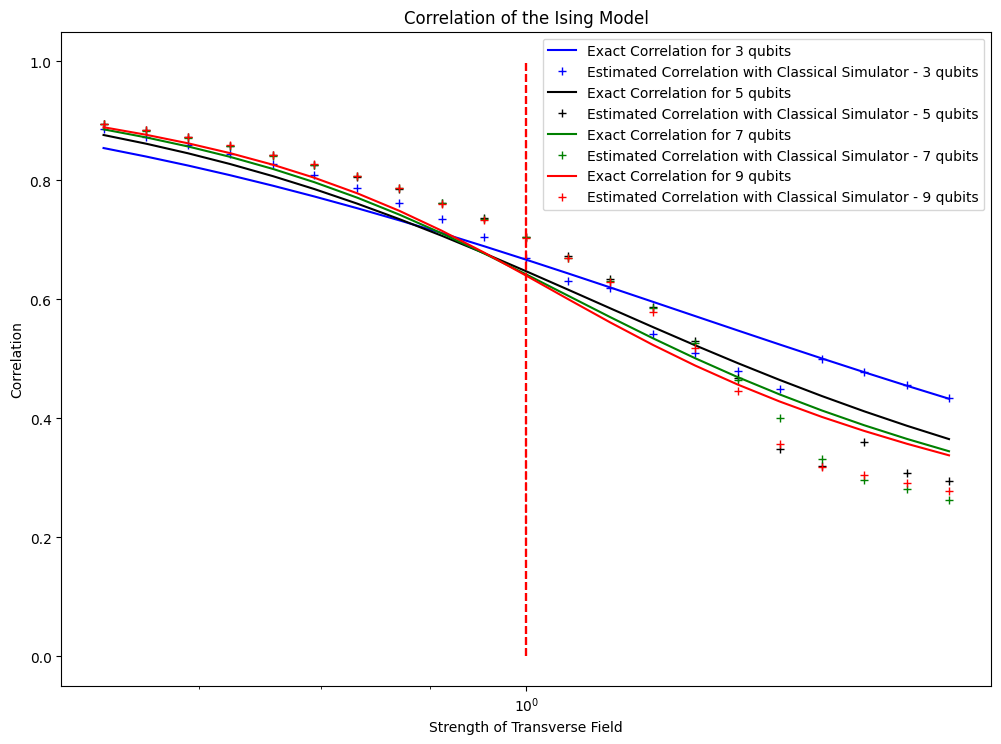

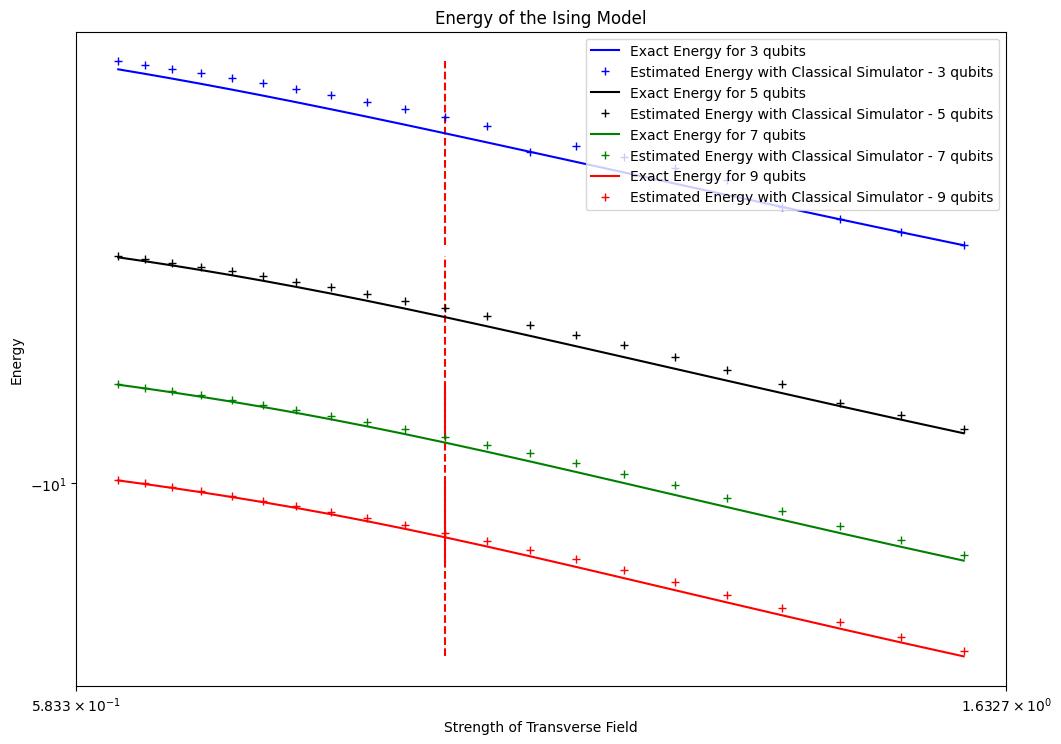

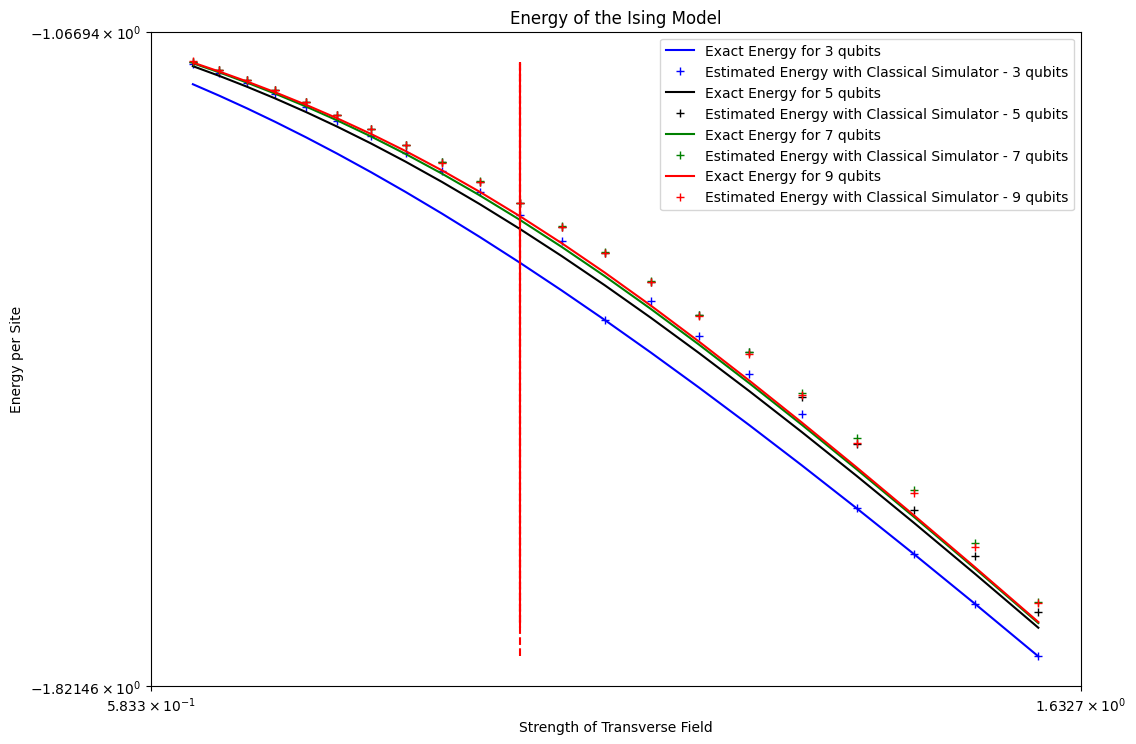

In [218]:
# Run on 12/6/2022 after above block (to find datafile)

d_text_coords_c = (0.7,0.3)
o_text_coords_c = (0.1,0.8)
arr_coords_c = (0.4, 0.4, 0.08, 0.08)
lab_coords_c = (0.3, 0.35)

d_text_coords_e = (0.7,0.5)
o_text_coords_e = (0.05,0.6)
arr_coords_e = (0.12, 0.4, 0.08, 0.08)
lab_coords_e = (0.06, 0.35)

colors = [["blue", "blue"],["black","black"], 
                            ["green", "green"], ["red","red"]]
          
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
backend = Aer.get_backend('statevector_simulator')

for idx, num_q in enumerate([3,5,7,9]):
    
    print(" ")
    print(f"Model with {num_q} qubits")

    shots = 2048
    max_iters = 100
    loop_iters = 21
    max_g = 0.2
    min_g= -0.2
    rot_blocks = 2

    optimizer = SLSQP(maxiter=max_iters, ftol = 1e-8)

    results_n = run_sim(provider, backend, max_g, min_g, num_q, optimizer, rot_blocks = rot_blocks,
                      shots = shots, loop_iters = loop_iters, verbose = True, quantum = False, minimize_circ = True)

    gs_n = results_n[0]
    exact_energies_n = results_n[1]
    est_energies_n = results_n[2]
    exact_corrs_n = results_n[3]
    est_corrs_n = results_n[4]
    
    fig_c_n, ax_c_n = plot_correlations(num_q,gs_n,exact_corrs_n, est_corrs_n,
                      fig = fig1, ax = ax1, colors = colors[idx])
    
        
    fig_e_n, ax_e_n = plot_energies(num_q,gs_n,exact_energies_n, est_energies_n,
                      fig = fig2, ax = ax2, colors = colors[idx])
    
    
    fig_e_n_s, ax_e_n_s = plot_energies(num_q,gs_n,np.array(exact_energies_n)/num_q, np.array(est_energies_n)/num_q,
                      fig = fig3, ax = ax3, colors = colors[idx], per_site = True)

In [219]:
fig_c_n, ax_c_n= write_text(fig_c_n,ax_c_n, o_text_coords_c,d_text_coords_c, arr_coords_c, lab_coords_c)
fig_e_n, ax_e_n= write_text(fig_e_n,ax_e_n, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)
fig_e_n_s, ax_e_n_s= write_text(fig_e_n_s,ax_e_n_s, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)

fig_c_n.savefig(os.path.join(os.getcwd(), "images", "Correlation_multiple_qubits_phase_region.jpg"))
fig_e_n.savefig(os.path.join(os.getcwd(), "images", "Energy_multiple_qubits_phase_region.jpg"))
fig_e_n_s.savefig(os.path.join(os.getcwd(), "images", "Energy_per_site_multiple_qubits_phase_region.jpg"))

## Approach g = 1 from large g

 
Model with 3 qubits
Running VQE
Running Ising Hamiltonian with g=1.0
Exact Energy: -4.000+0.000j, Estimate Energy: -3.836
Exact Correlation: 0.667+0.000j, Estimate Correlation: 0.670+0.000j
Running Ising Hamiltonian with g=1.259
Exact Energy: -4.562+0.000j, Estimate Energy: -4.384
Exact Correlation: 0.548+0.000j, Estimate Correlation: 0.479+0.000j
Running Ising Hamiltonian with g=1.585
Exact Energy: -5.361+0.000j, Estimate Energy: -5.361
Exact Correlation: 0.433+0.000j, Estimate Correlation: 0.434+0.000j
Running Ising Hamiltonian with g=1.995
Exact Energy: -6.450+0.000j, Estimate Energy: -6.450
Exact Correlation: 0.334+0.000j, Estimate Correlation: 0.335+0.000j
Running Ising Hamiltonian with g=2.512
Exact Energy: -7.893+0.000j, Estimate Energy: -7.782
Exact Correlation: 0.255+0.000j, Estimate Correlation: 0.183+0.000j
Running Ising Hamiltonian with g=3.162
Exact Energy: -9.761+0.000j, Estimate Energy: -9.761
Exact Correlation: 0.195+0.000j, Estimate Correlation: 0.194+0.000j
Running 

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Exact Energy: -6.472+0.000j, Estimate Energy: -6.322
Exact Correlation: 0.647+0.000j, Estimate Correlation: 0.706+0.000j
Running Ising Hamiltonian with g=1.259
Exact Energy: -7.407+0.000j, Estimate Energy: -7.182
Exact Correlation: 0.493+0.000j, Estimate Correlation: 0.468+0.000j
Running Ising Hamiltonian with g=1.585
Exact Energy: -8.771+0.000j, Estimate Energy: -8.681
Exact Correlation: 0.365+0.000j, Estimate Correlation: 0.295+0.000j
Running Ising Hamiltonian with g=1.995
Exact Energy: -10.627-0.000j, Estimate Energy: -10.581
Exact Correlation: 0.274+0.000j, Estimate Correlation: 0.236-0.000j
Running Ising Hamiltonian with g=2.512
Exact Energy: -13.069+0.000j, Estimate Energy: -13.051
Exact Correlation: 0.209+0.000j, Estimate Correlation: 0.195-0.000j
Running Ising Hamiltonian with g=3.162
Exact Energy: -16.210+0.000j, Estimate Energy: -16.170
Exact Correlation: 0.163+0.000j, Estimate Correlation: 0.140+0.000j
Running Ising Hamiltonian with g=3.981
Exact Energy: -20.221+0.000j, Esti

Exact Energy: -57.147-0.000j, Estimate Energy: -56.992
Exact Correlation: 0.079+0.000j, Estimate Correlation: 0.045-0.000j
Running Ising Hamiltonian with g=7.943
Exact Energy: -71.771-0.000j, Estimate Energy: -71.655
Exact Correlation: 0.063-0.000j, Estimate Correlation: 0.035+0.000j
Running Ising Hamiltonian with g=10.0
Exact Energy: -90.225+0.000j, Estimate Energy: -90.139
Exact Correlation: 0.050+0.000j, Estimate Correlation: 0.029+0.000j
Running Ising Hamiltonian with g=12.589
Exact Energy: -113.480-0.000j, Estimate Energy: -113.321
Exact Correlation: 0.040+0.000j, Estimate Correlation: 0.005-0.000j
Running Ising Hamiltonian with g=15.849
Exact Energy: -142.783-0.000j, Estimate Energy: -142.657
Exact Correlation: 0.032+0.000j, Estimate Correlation: 0.003+0.000j
Running Ising Hamiltonian with g=19.953
Exact Energy: -179.690+0.000j, Estimate Energy: -179.590
Exact Correlation: 0.025+0.000j, Estimate Correlation: 0.003-0.000j
Running Ising Hamiltonian with g=25.119
Exact Energy: -226.

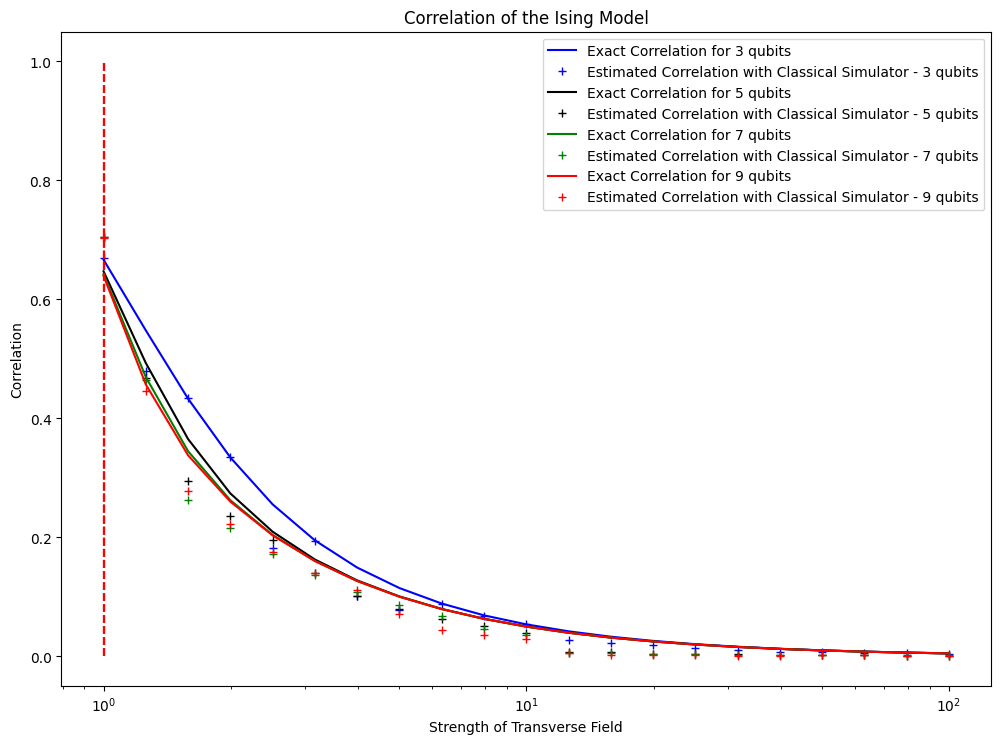

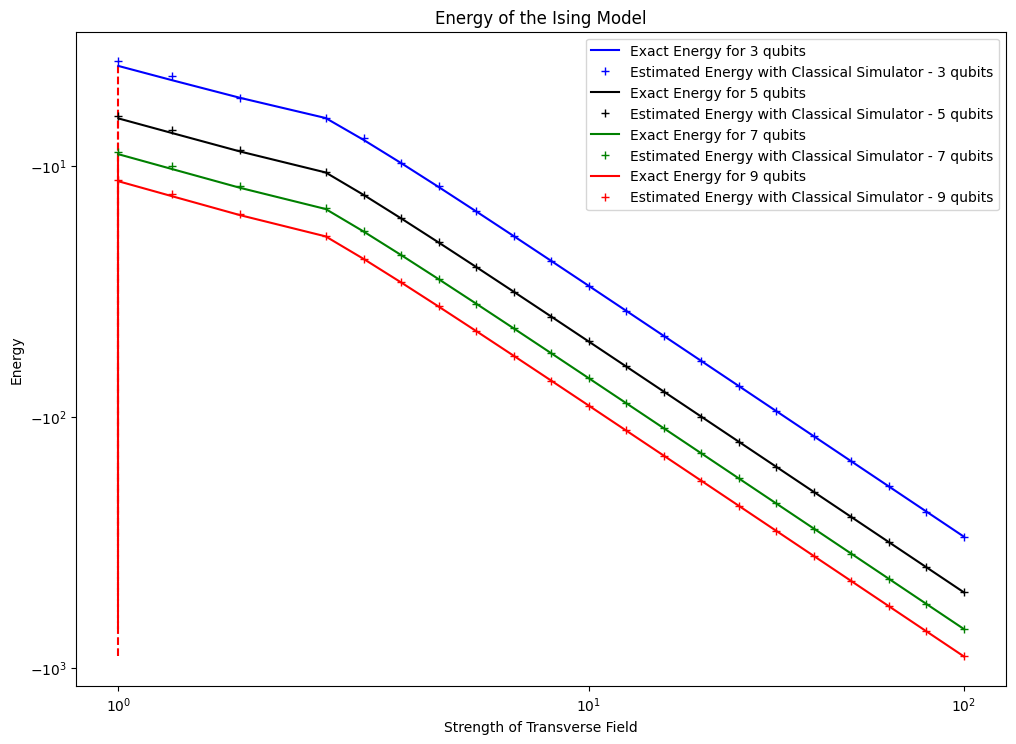

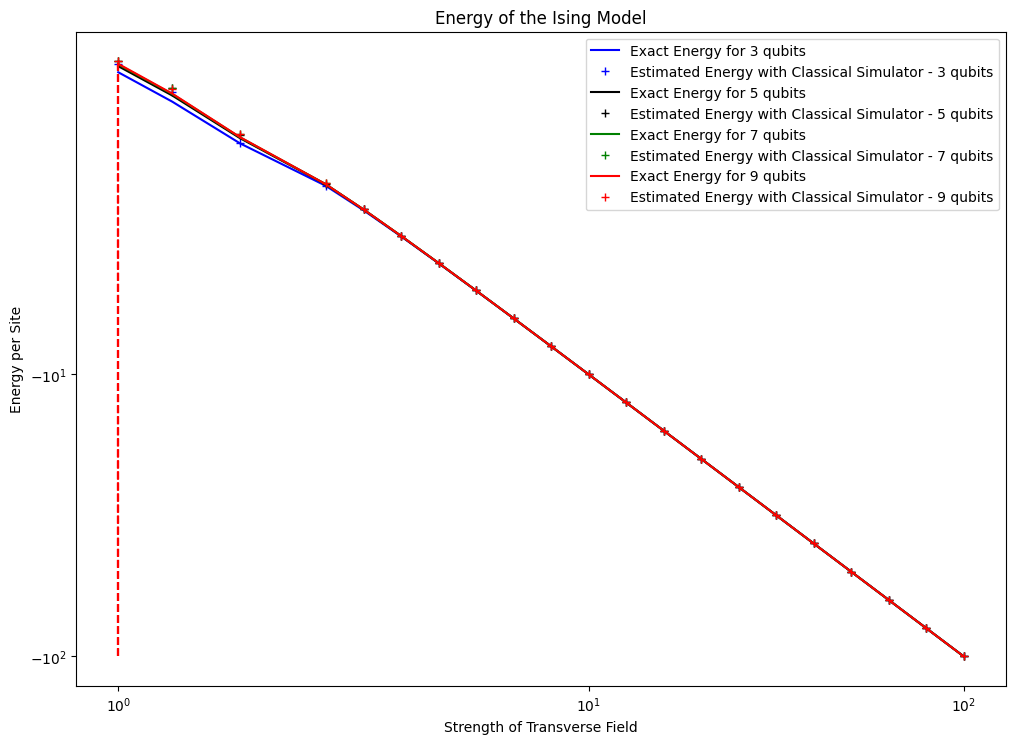

In [26]:
# Run on 12/6/2022 after above block (to find datafile)

d_text_coords_c = (0.7,0.3)
o_text_coords_c = (0.1,0.8)
arr_coords_c = (0.4, 0.4, 0.08, 0.08)
lab_coords_c = (0.3, 0.35)

d_text_coords_e = (0.7,0.5)
o_text_coords_e = (0.05,0.6)
arr_coords_e = (0.12, 0.4, 0.08, 0.08)
lab_coords_e = (0.06, 0.35)

colors = [["blue", "blue"],["black","black"], 
                            ["green", "green"], ["red","red"]]
          
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
backend = Aer.get_backend('statevector_simulator')

for idx, num_q in enumerate([3,5,7,9]):
    
    print(" ")
    print(f"Model with {num_q} qubits")

    shots = 2048
    max_iters = 100
    loop_iters = 21
    max_g = 2
    min_g= 0
    rot_blocks = 2

    optimizer = SLSQP(maxiter=max_iters, ftol = 1e-8)

    results_n = run_sim(provider, backend, max_g, min_g, num_q, optimizer, rot_blocks = rot_blocks,
                      shots = shots, loop_iters = loop_iters, verbose = True, quantum = False, minimize_circ = True)

    gs_n = results_n[0]
    exact_energies_n = results_n[1]
    est_energies_n = results_n[2]
    exact_corrs_n = results_n[3]
    est_corrs_n = results_n[4]
    
    fig_c_n, ax_c_n = plot_correlations(num_q,gs_n,exact_corrs_n, est_corrs_n,
                      fig = fig1, ax = ax1, colors = colors[idx])
    
        
    fig_e_n, ax_e_n = plot_energies(num_q,gs_n,exact_energies_n, est_energies_n,
                      fig = fig2, ax = ax2, colors = colors[idx])
    
    
    fig_e_n_s, ax_e_n_s = plot_energies(num_q,gs_n,np.array(exact_energies_n)/num_q, np.array(est_energies_n)/num_q,
                      fig = fig3, ax = ax3, colors = colors[idx], per_site = True)

In [27]:
fig_c_n, ax_c_n= write_text(fig_c_n,ax_c_n, o_text_coords_c,d_text_coords_c, arr_coords_c, lab_coords_c)
fig_e_n, ax_e_n= write_text(fig_e_n,ax_e_n, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)
fig_e_n_s, ax_e_n_s= write_text(fig_e_n_s,ax_e_n_s, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)

fig_c_n.savefig(os.path.join(os.getcwd(), "images", "Correlation_multiple_qubits_large_g.jpg"))
fig_e_n.savefig(os.path.join(os.getcwd(), "images", "Energy_multiple_qubits_large_g.jpg"))
fig_e_n_s.savefig(os.path.join(os.getcwd(), "images", "Energy_per_site_multiple_qubits_large_g.jpg"))

 
Model with 3 qubits
Running VQE
Running Ising Hamiltonian with g=1.259
Exact Energy: -4.562+0.000j, Estimate Energy: -4.384
Exact Correlation: 0.548+0.000j, Estimate Correlation: 0.479+0.000j
Running Ising Hamiltonian with g=1.318
Exact Energy: -4.701+0.000j, Estimate Energy: -4.524
Exact Correlation: 0.524+0.000j, Estimate Correlation: 0.450+0.000j
Running Ising Hamiltonian with g=1.38
Exact Energy: -4.849+0.000j, Estimate Energy: -4.849
Exact Correlation: 0.501+0.000j, Estimate Correlation: 0.501+0.000j
Running Ising Hamiltonian with g=1.445
Exact Energy: -5.009+0.000j, Estimate Energy: -5.009
Exact Correlation: 0.478+0.000j, Estimate Correlation: 0.477+0.000j
Running Ising Hamiltonian with g=1.514
Exact Energy: -5.181+0.000j, Estimate Energy: -5.181
Exact Correlation: 0.455+0.000j, Estimate Correlation: 0.456-0.000j
Running Ising Hamiltonian with g=1.585
Exact Energy: -5.361+0.000j, Estimate Energy: -5.361
Exact Correlation: 0.433+0.000j, Estimate Correlation: 0.434+0.000j
Running

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Exact Energy: -7.407+0.000j, Estimate Energy: -7.182
Exact Correlation: 0.493+0.000j, Estimate Correlation: 0.468+0.000j
Running Ising Hamiltonian with g=1.318
Exact Energy: -7.642+0.000j, Estimate Energy: -7.439
Exact Correlation: 0.465+0.000j, Estimate Correlation: 0.348+0.000j
Running Ising Hamiltonian with g=1.38
Exact Energy: -7.896+0.000j, Estimate Energy: -7.710
Exact Correlation: 0.438+0.000j, Estimate Correlation: 0.319+0.000j
Running Ising Hamiltonian with g=1.445
Exact Energy: -8.168+0.000j, Estimate Energy: -8.093
Exact Correlation: 0.412+0.000j, Estimate Correlation: 0.360+0.000j
Running Ising Hamiltonian with g=1.514
Exact Energy: -8.462-0.000j, Estimate Energy: -8.360
Exact Correlation: 0.388-0.000j, Estimate Correlation: 0.308+0.000j
Running Ising Hamiltonian with g=1.585
Exact Energy: -8.771+0.000j, Estimate Energy: -8.681
Exact Correlation: 0.365+0.000j, Estimate Correlation: 0.295+0.000j
Running Ising Hamiltonian with g=1.66
Exact Energy: -9.102+0.000j, Estimate Ener

Exact Energy: -17.643+0.000j, Estimate Energy: -17.481
Exact Correlation: 0.288+0.000j, Estimate Correlation: 0.244+0.000j
Running Ising Hamiltonian with g=1.905
Exact Energy: -18.349-0.000j, Estimate Energy: -18.197
Exact Correlation: 0.274+0.000j, Estimate Correlation: 0.233+0.000j
Running Ising Hamiltonian with g=1.995
Exact Energy: -19.102+0.000j, Estimate Energy: -18.960
Exact Correlation: 0.260+0.000j, Estimate Correlation: 0.223-0.000j
Running Ising Hamiltonian with g=2.089
Exact Energy: -19.895+0.000j, Estimate Energy: -19.761
Exact Correlation: 0.247+0.000j, Estimate Correlation: 0.213+0.000j
Running Ising Hamiltonian with g=2.188
Exact Energy: -20.735-0.000j, Estimate Energy: -20.608
Exact Correlation: 0.235+0.000j, Estimate Correlation: 0.204+0.000j
Running Ising Hamiltonian with g=2.291
Exact Energy: -21.614-0.000j, Estimate Energy: -21.494
Exact Correlation: 0.224+0.000j, Estimate Correlation: 0.194+0.000j
Running Ising Hamiltonian with g=2.399
Exact Energy: -22.540-0.000j

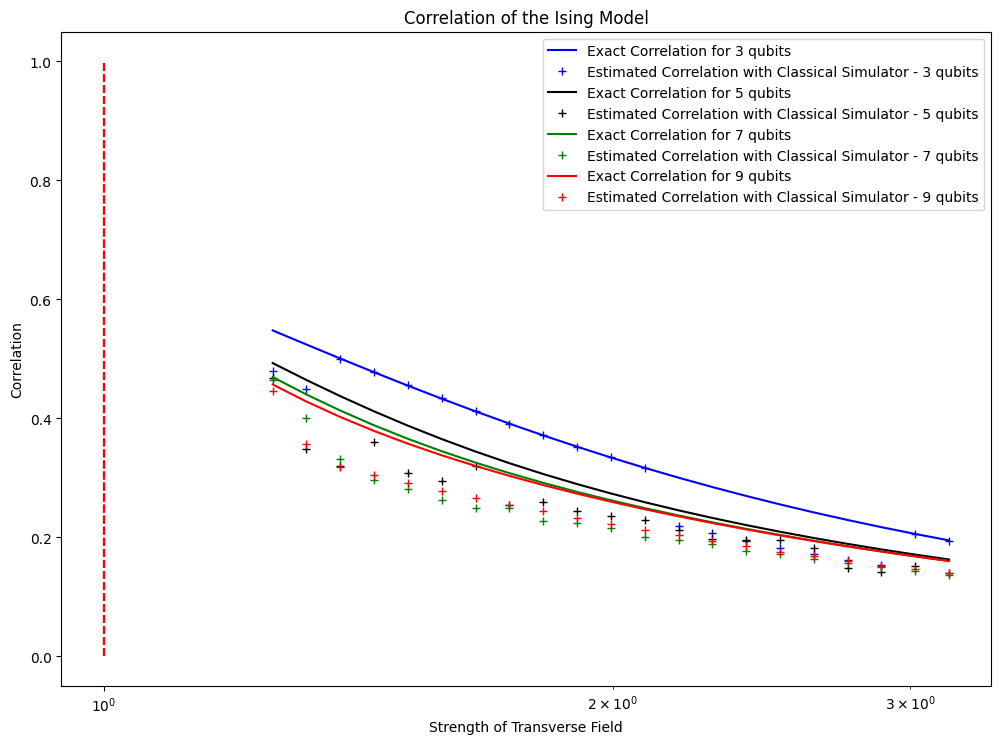

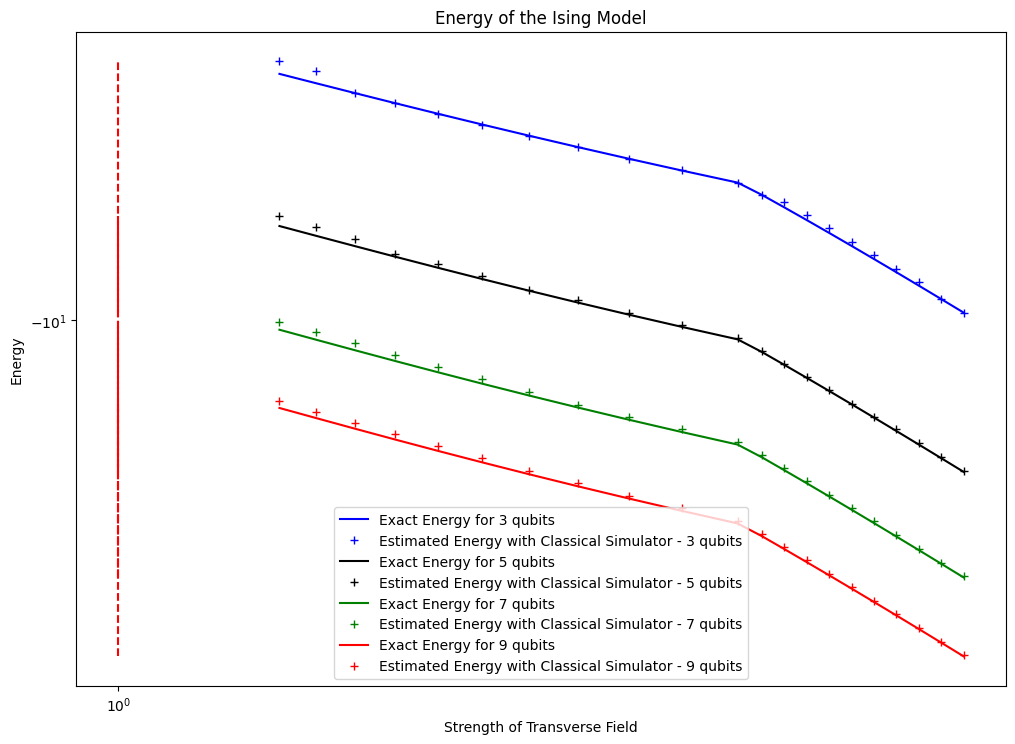

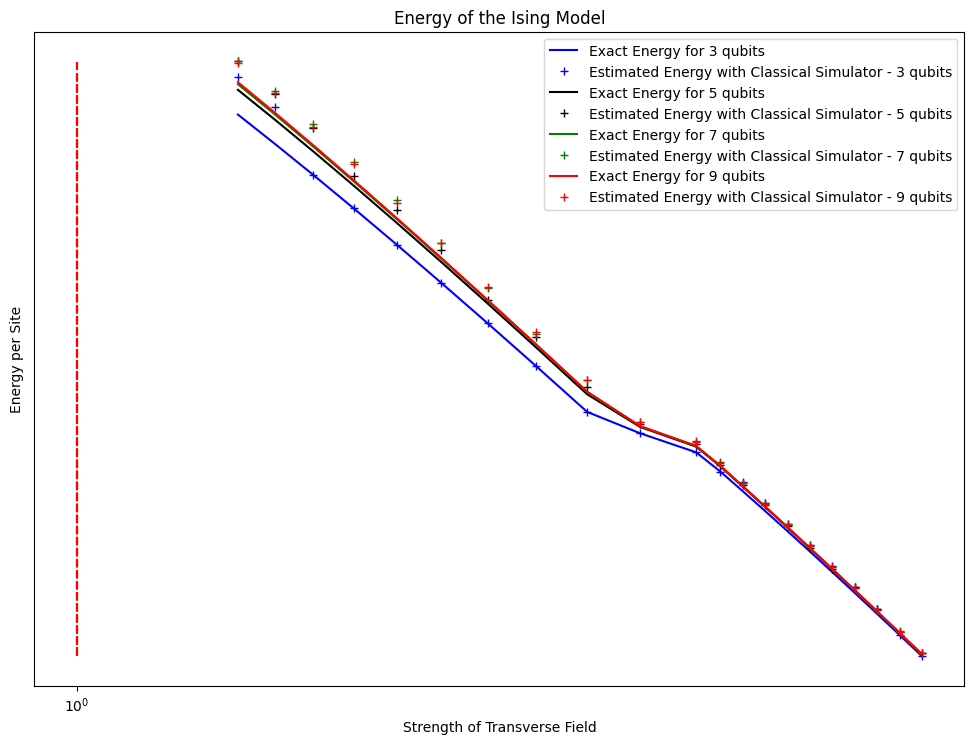

In [31]:
# Run on 12/6/2022 after above block (to find datafile)

d_text_coords_c = (0.7,0.3)
o_text_coords_c = (0.1,0.8)
arr_coords_c = (0.4, 0.4, 0.08, 0.08)
lab_coords_c = (0.3, 0.35)

d_text_coords_e = (0.7,0.5)
o_text_coords_e = (0.05,0.6)
arr_coords_e = (0.12, 0.4, 0.08, 0.08)
lab_coords_e = (0.06, 0.35)

colors = [["blue", "blue"],["black","black"], 
                            ["green", "green"], ["red","red"]]
          
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
backend = Aer.get_backend('statevector_simulator')

for idx, num_q in enumerate([3,5,7,9]):
    
    print(" ")
    print(f"Model with {num_q} qubits")

    shots = 2048
    max_iters = 100
    loop_iters = 21
    max_g = 0.5
    min_g= 0.1
    rot_blocks = 2

    optimizer = SLSQP(maxiter=max_iters, ftol = 1e-8)

    results_n = run_sim(provider, backend, max_g, min_g, num_q, optimizer, rot_blocks = rot_blocks,
                      shots = shots, loop_iters = loop_iters, verbose = True, quantum = False, minimize_circ = True)

    gs_n = results_n[0]
    exact_energies_n = results_n[1]
    est_energies_n = results_n[2]
    exact_corrs_n = results_n[3]
    est_corrs_n = results_n[4]
    
    fig_c_n, ax_c_n = plot_correlations(num_q,gs_n,exact_corrs_n, est_corrs_n,
                      fig = fig1, ax = ax1, colors = colors[idx])
    
        
    fig_e_n, ax_e_n = plot_energies(num_q,gs_n,exact_energies_n, est_energies_n,
                      fig = fig2, ax = ax2, colors = colors[idx])
    
    
    fig_e_n_s, ax_e_n_s = plot_energies(num_q,gs_n,np.array(exact_energies_n)/num_q, np.array(est_energies_n)/num_q,
                      fig = fig3, ax = ax3, colors = colors[idx], per_site = True)

In [32]:
fig_c_n, ax_c_n= write_text(fig_c_n,ax_c_n, o_text_coords_c,d_text_coords_c, arr_coords_c, lab_coords_c)
fig_e_n, ax_e_n= write_text(fig_e_n,ax_e_n, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)
fig_e_n_s, ax_e_n_s= write_text(fig_e_n_s,ax_e_n_s, o_text_coords_e,d_text_coords_e, arr_coords_e, lab_coords_e)

fig_c_n.savefig(os.path.join(os.getcwd(), "images", "Correlation_multiple_qubits_large_g_10.jpg"))
fig_e_n.savefig(os.path.join(os.getcwd(), "images", "Energy_multiple_qubits_large_g_10.jpg"))
fig_e_n_s.savefig(os.path.join(os.getcwd(), "images", "Energy_per_site_multiple_qubits_large_g_10.jpg"))

In [28]:
backend = Aer.get_backend('statevector_simulator')

shots = 2048
max_iters = 100
loop_iters = 21
max_g = 2
min_g= -2
rot_blocks = 2
num_qubits = 3

optimizer = SPSA(maxiter=max_iters)

results_f = run_sim_frustration(provider, backend, max_g, min_g, num_qubits, optimizer, rot_blocks = rot_blocks,
                  shots = shots, loop_iters = loop_iters, verbose = True, quantum = False, minimize_circ = True)
    
gs_f = results_f[0]
exact_energies_f = results_f[1]
est_energies_f = results_f[2]
exact_corrs_f = results_f[3]
est_corrs_f = results_f[4]

Running VQE
Running Ising Hamiltonian with g=0.01
Exact Energy: -1.020+0.000j, Estimate Energy: -0.981
Exact Correlation: -0.333+0.000j, Estimate Correlation: -0.327+0.000j
Running Ising Hamiltonian with g=0.016
Exact Energy: -1.032+0.000j, Estimate Energy: -0.999
Exact Correlation: -0.333+0.000j, Estimate Correlation: -0.333+0.000j
Running Ising Hamiltonian with g=0.025
Exact Energy: -1.050+0.000j, Estimate Energy: -0.998
Exact Correlation: -0.333+0.000j, Estimate Correlation: -0.333+0.000j
Running Ising Hamiltonian with g=0.04
Exact Energy: -1.081+0.000j, Estimate Energy: -1.011
Exact Correlation: -0.333+0.000j, Estimate Correlation: -0.331-0.000j
Running Ising Hamiltonian with g=0.063
Exact Energy: -1.129+0.000j, Estimate Energy: -0.959
Exact Correlation: -0.332+0.000j, Estimate Correlation: -0.332+0.000j
Running Ising Hamiltonian with g=0.1
Exact Energy: -1.207+0.000j, Estimate Energy: -1.151
Exact Correlation: -0.331+0.000j, Estimate Correlation: -0.330+0.000j
Running Ising Hamilt

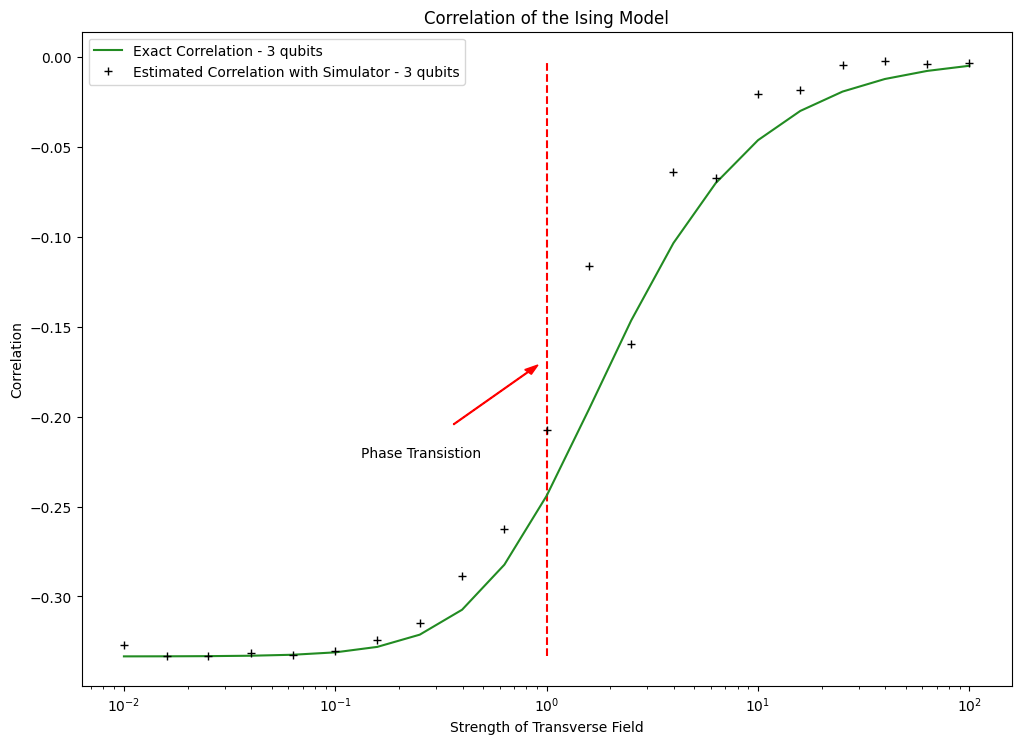

In [32]:
# finished 12/6/2022 at 2013

d_text_coords = (0.7,0.4)
o_text_coords = (0.1,0.8)
arr_coords = (0.4, 0.4, 0.08, 0.08)
lab_coords = (0.3, 0.35)

fig_c_f, ax_c_f = plot_correlations(num_qubits,gs_f,exact_corrs_f, est_corrs_f,
                  quantum = False)


fig_c_f, ax_c_f = write_text_frust(fig_c_f,ax_c_f, arr_coords, lab_coords)


fig_c_f.savefig(os.path.join(os.getcwd(), "images", "Correlation_5_qubits_frusturation.jpg"))

C:\Users\joshr\anaconda3\envs\quantum\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


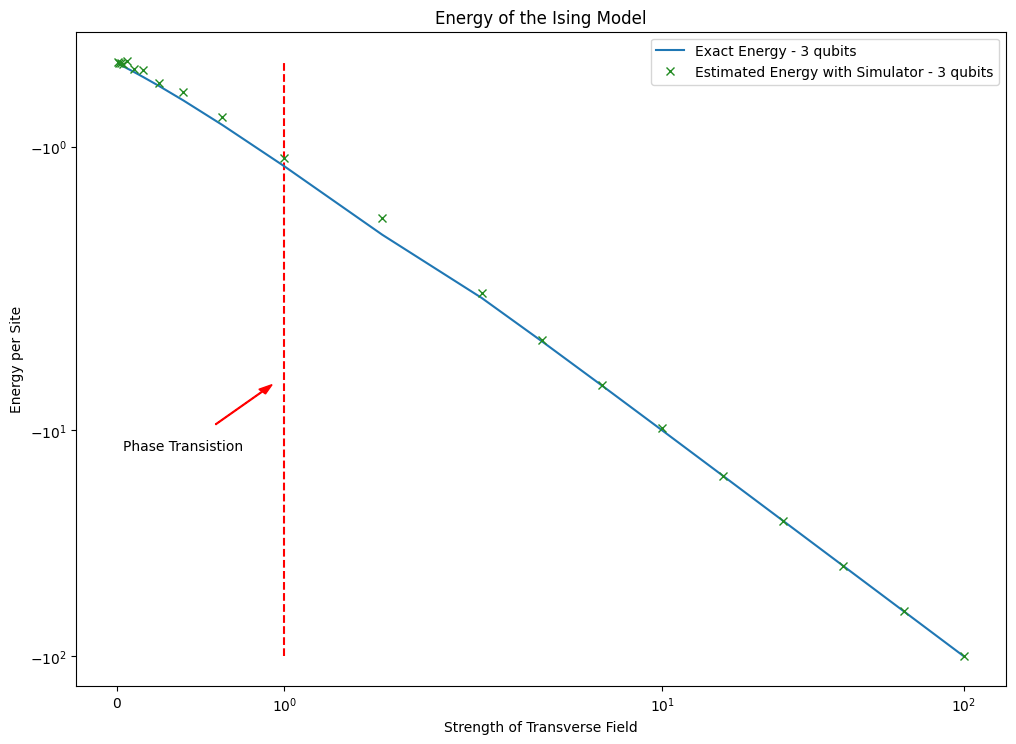

In [33]:
d_text_coords = (0.7,0.5)
o_text_coords = (0.05,0.6)
arr_coords = (0.15, 0.4, 0.05, 0.05)
lab_coords = (0.05, 0.36)

fig_e_f_s, ax_e_f_s = plot_energies(num_qubits,gs_f,np.array(exact_energies_f)/num_qubits, 
              np.array(est_energies_f)/num_qubits, per_site = True)
    

fig_e_f_s, ax_e_f_s = write_text_frust(fig_e_f_s,ax_e_f_s, arr_coords, lab_coords)


fig_e_f_s.savefig(os.path.join(os.getcwd(), "images", "Energy_per_site_5_qubits_frusturation.jpg"))